In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from collections import defaultdict

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from lib.simdata_i3 import I3SimHandler

from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

import time

from collections import defaultdict

In [3]:
dtype = jnp.float64

event_ids = ['1022', '10393', '10644', '10738', '11086', '11232', '13011',
       '13945', '14017', '14230', '15243', '16416', '16443', '1663',
       '1722', '17475', '18846', '19455', '20027', '21113', '21663',
       '22232', '22510', '22617', '23574', '23638', '23862', '24530',
       '24726', '25181', '25596', '25632', '27063', '27188', '27285',
       '28188', '28400', '29040', '29707', '3062', '31920', '31989',
       '32781', '32839', '33119', '33656', '34506', '35349', '37086',
       '37263', '37448', '37786', '37811', '39166', '39962', '40023',
       '41381', '41586', '42566', '42568', '42677', '43153', '43483',
       '4397', '44081', '48309', '48448', '48632', '49067', '50832',
       '51687', '51956', '54374', '55301', '55526', '55533', '56041',
       '5620', '56741', '56774', '57174', '57394', '57723', '59010',
       '59029', '59089', '59099', '59228', '62274', '62512', '63373',
       '65472', '6586', '8', '8604', '8674', '8840', '9410', '9419',
       '9505']

In [110]:
class I3SimHandlerAllPulses(I3SimHandler):
    def __init__(self, events_meta_file: str = None,
                 events_pulses_file: str = None,
                 geo_file: str = None,
                 df_meta: pd.DataFrame = None,
                 df_pulses: pd.DataFrame = None) -> None:
        super().__init__(events_meta_file, events_pulses_file, geo_file, df_meta, df_pulses)


    def get_data_w_early_pulse_criterion(self, meta, pulses, delta_times=None):
        event_data = self.get_per_dom_summary_from_sim_data(meta, pulses)

        if delta_times is None:
            delta_times = [10, 15, 20] # count fractional charge for t in [X0, X0+delta] 
        
        ratios = defaultdict(list)
        for i, row in event_data[['sensor_id', 'charge', 'time']].iterrows():                
            sensor_id, q_tot, first_time = row['sensor_id'], row['charge'], row['time']
            idx = pulses['sensor_id'] == sensor_id
            pulses_this_dom = pulses[idx]
        
            for delta in delta_times:
                time_threshold = first_time + delta
                idx_c = pulses_this_dom['time'] < time_threshold
                ratios[delta].append(pulses_this_dom[idx_c]['charge'].sum() / q_tot)
               
        for r in ratios:
            event_data[f'ratio_{r}'] = ratios[r]

        return event_data    

In [111]:
event_id = 20027
bp = '/home/storage2/hans/i3files/alerts/bfrv2/'
sim_handler = I3SimHandlerAllPulses(os.path.join(bp, f'meta_ds_event_{event_id}_N100_from_0_to_100_1st_pulse_charge_correction.ftr'),
                              os.path.join(bp, f'pulses_ds_event_{event_id}_N100_from_0_to_100_1st_pulse_charge_correction.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

pdf = PdfPages(f"early_pulses_{event_id}_investigation.pdf")

delta_times = [10, 15, 20]

hit_x = []
hit_y = []
hit_z = []
hit_t = []
hit_q = []
hit_frac_10 = []
hit_frac_15 = []
hit_frac_20 = []

for i in list(range(100)):
    try:
        meta, pulses = sim_handler.get_event_data(i)
    except:
        continue

    #print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

    track_time = meta['muon_time']
    track_pos = [meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']]
    track_dir = [meta['muon_zenith'], meta['muon_azimuth']]

    # Get dom locations, first hit times, and total charges (for each dom).
    #event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    event_data = sim_handler.get_data_w_early_pulse_criterion(meta, pulses, delta_times)
    
    hit_t.append(event_data['time'].values - track_time)
    hit_x.append(event_data['x'].values)
    hit_y.append(event_data['y'].values)
    hit_z.append(event_data['z'].values)
    hit_q.append(event_data['charge'].values)
    hit_frac_10.append(event_data['ratio_10'].values)
    hit_frac_15.append(event_data['ratio_15'].values)
    hit_frac_20.append(event_data['ratio_20'].values)

In [112]:
    dom_data = defaultdict(lambda: defaultdict(list))

    for i in range(len(hit_x)):
        for j in range(len(hit_x[i])):
            x = hit_x[i][j]
            y = hit_y[i][j]
            z = hit_z[i][j]
            dom_data[(x,y,z)]['first_hit_time'].append(hit_t[i][j])
            dom_data[(x,y,z)]['q_tot'].append(hit_q[i][j])
            dom_data[(x,y,z)]['ratio_10'].append(hit_frac_10[i][j])
            dom_data[(x,y,z)]['ratio_15'].append(hit_frac_15[i][j])
            dom_data[(x,y,z)]['ratio_20'].append(hit_frac_20[i][j])

    for key in dom_data.keys():
        qs = dom_data[key]['q_tot']
        dom_data[key]['mean_q_tot'] = np.median(qs)

    sorting = 'distance'

    dom_pos = []
    for key in dom_data.keys():
        dom_pos.append(jnp.array(key).reshape((1,3)))

    dom_pos = jnp.concatenate(dom_pos, axis=0)
    track_pos = jnp.array(track_pos)
    track_dir = jnp.array(track_dir)

    # get also the other DOM info
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)

    geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
                cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                             track_pos,
                                             track_dir_xyz)

In [113]:
    sorting = 'charge'

    # convert first_hit_times to delay_times by subtracting geo_times
    # and add more dom data to dom_data dict
    for i in range(len(dom_pos)):
        pos = tuple(np.array(dom_pos[i]))
        gt = geo_time[i]
        for j in range(len(dom_data[pos]['first_hit_time'])):
            dom_data[pos]['first_hit_time'][j] -= float(gt)

        dom_data[pos]['closest_approach_dist'] = closest_approach_dist[i]
        dom_data[pos]['closest_approach_rho'] = closest_approach_rho[i]
        dom_data[pos]['closest_approach_z'] = closest_approach_z[i]

    # charge sorted mapping
    dom_positions = list(dom_data.keys())

    if sorting == 'charge':
        dom_positions.sort(key=lambda x: dom_data[x]['mean_q_tot'], reverse=True)
    else:
        dom_positions.sort(key=lambda x: dom_data[x]['closest_approach_dist'] ,reverse=False)

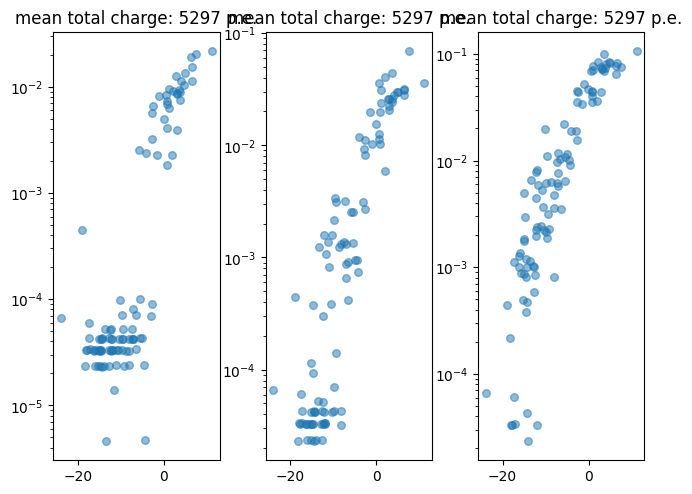

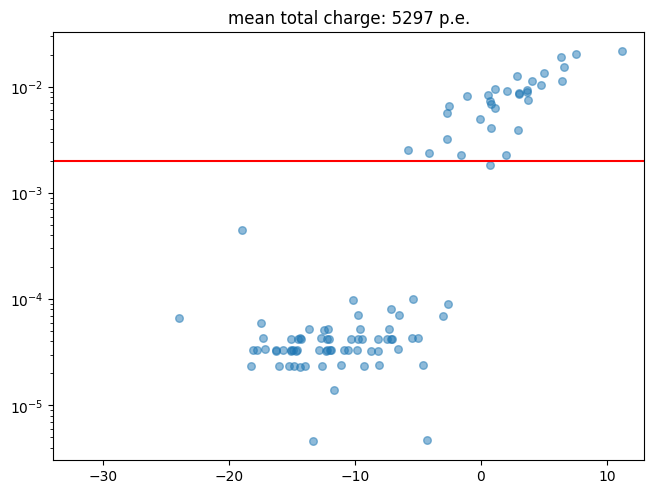

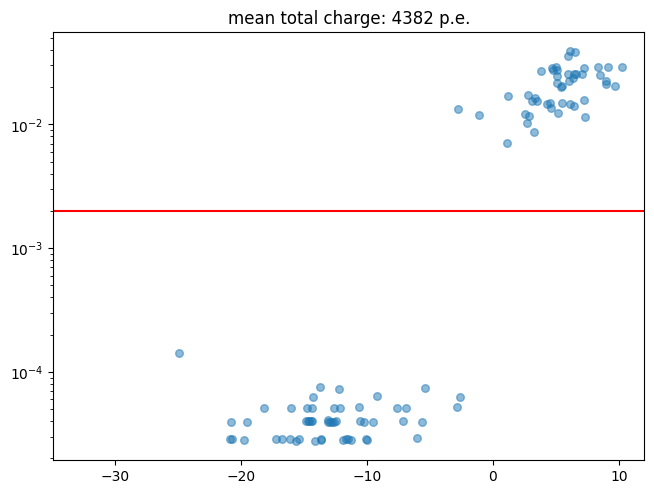

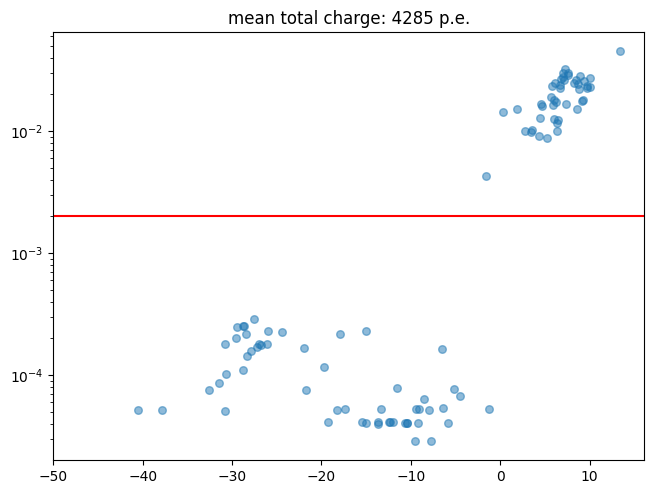

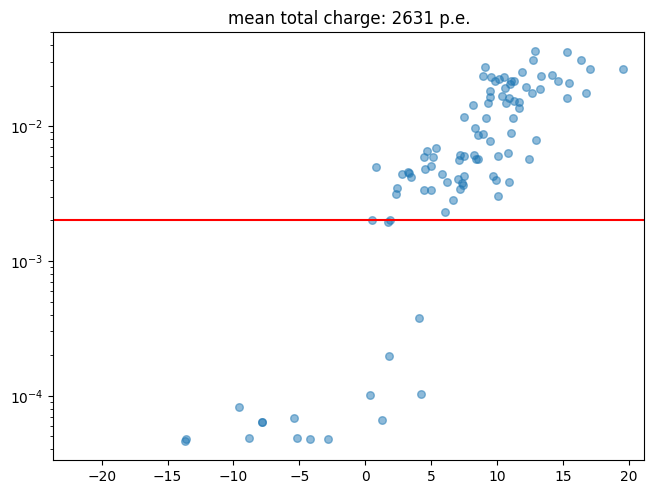

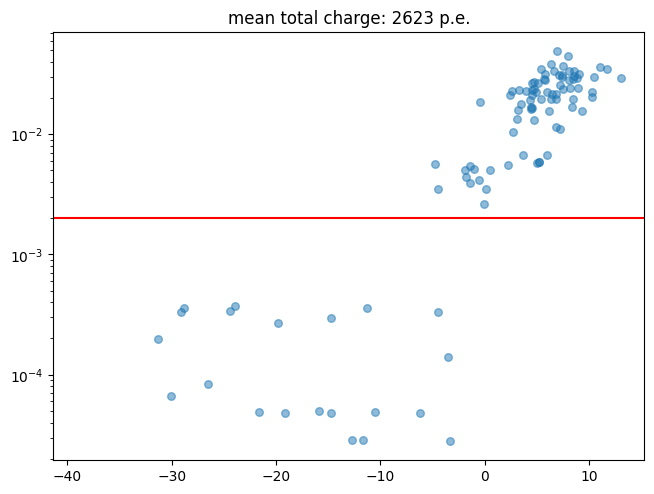

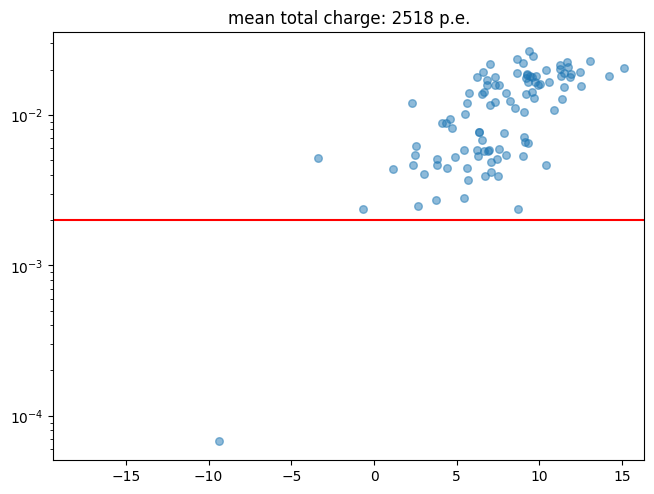

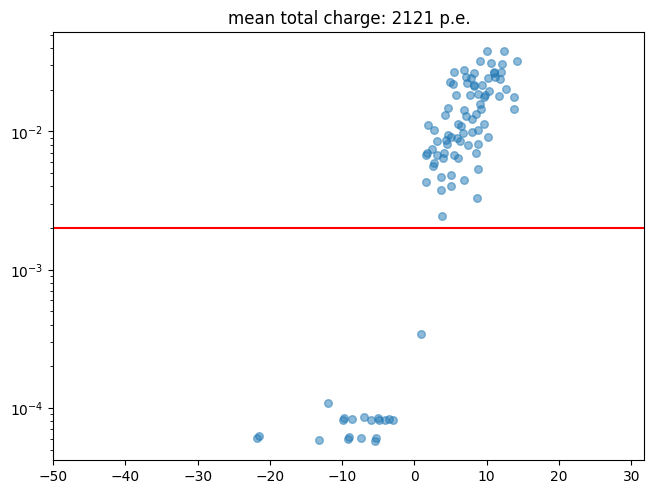

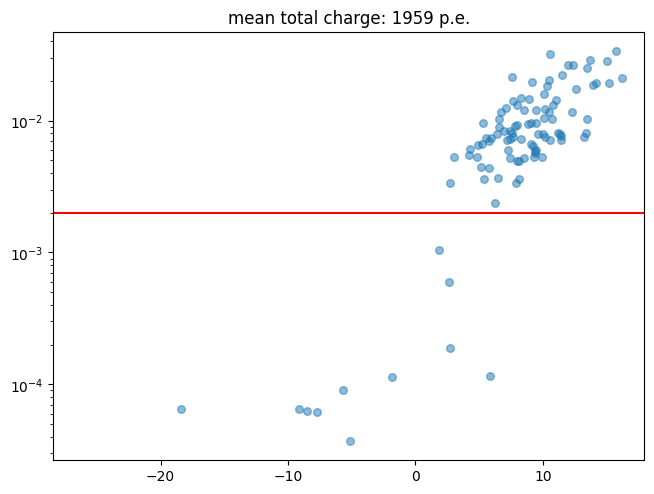

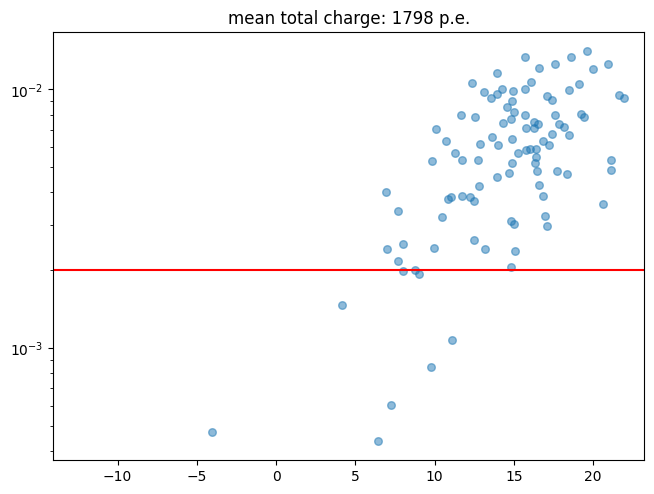

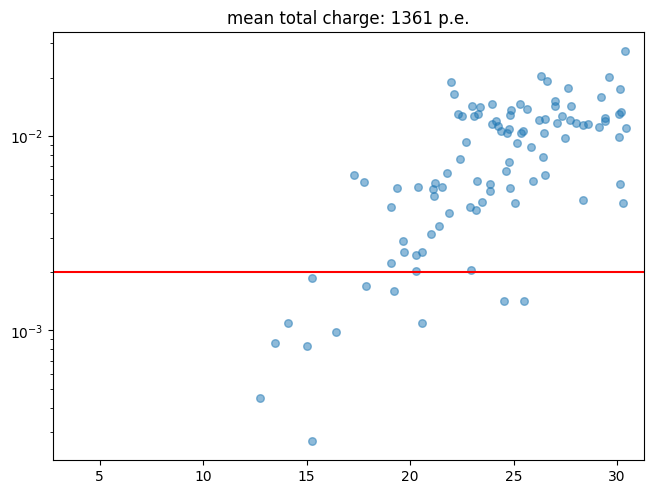

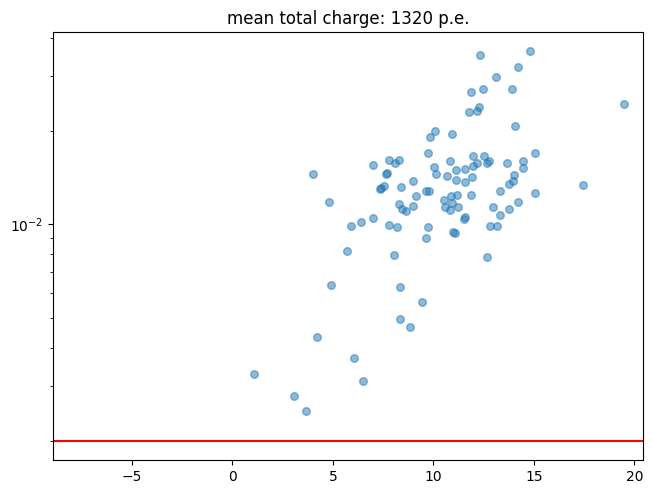

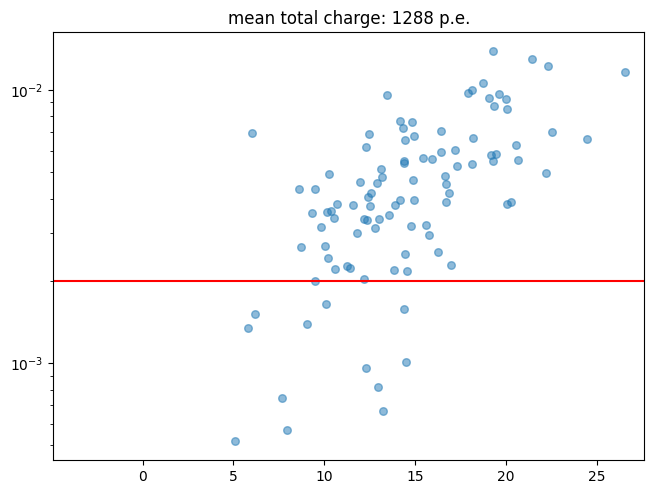

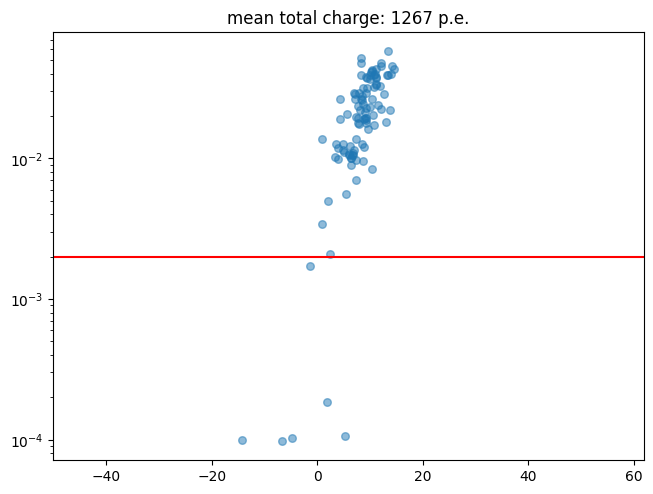

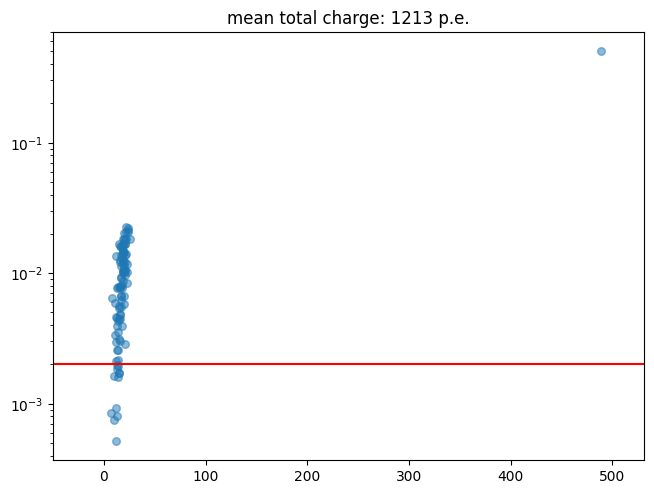

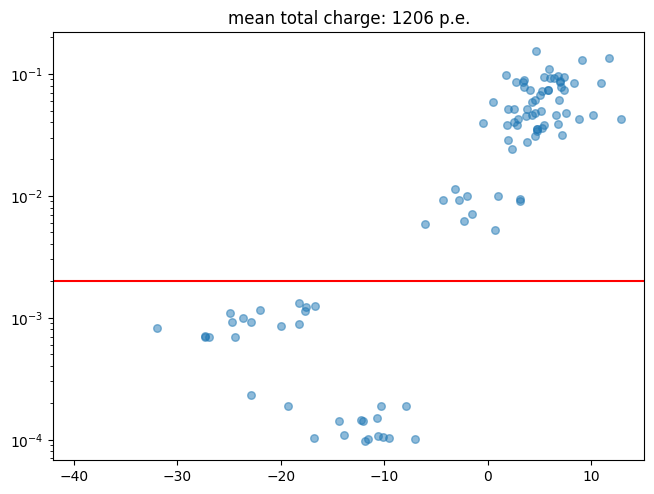

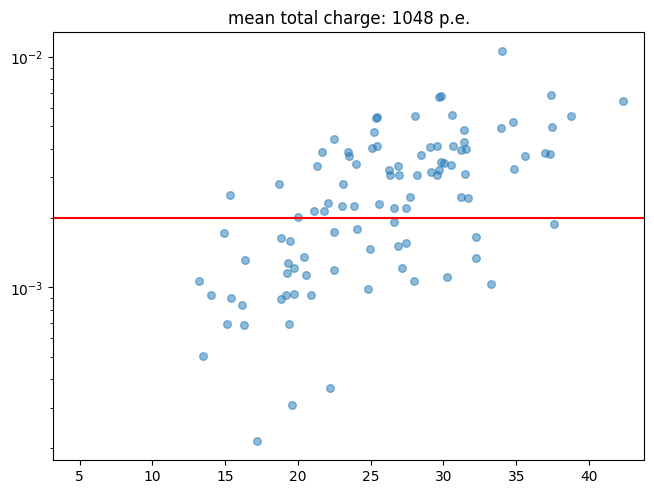

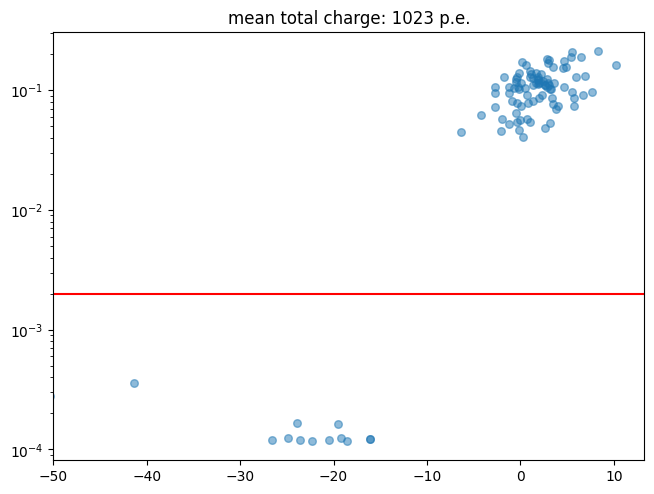

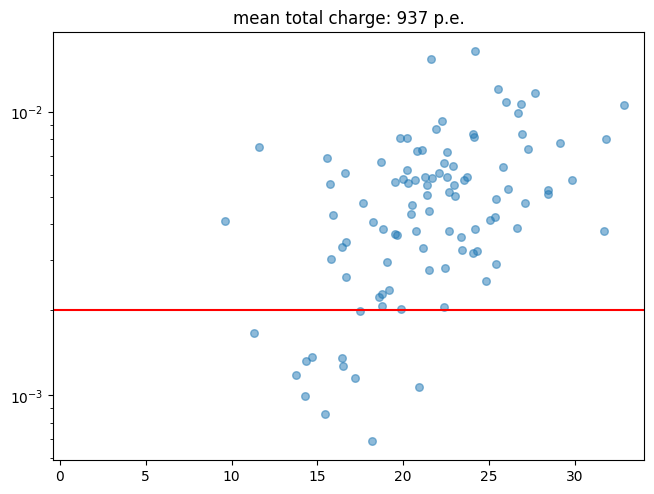

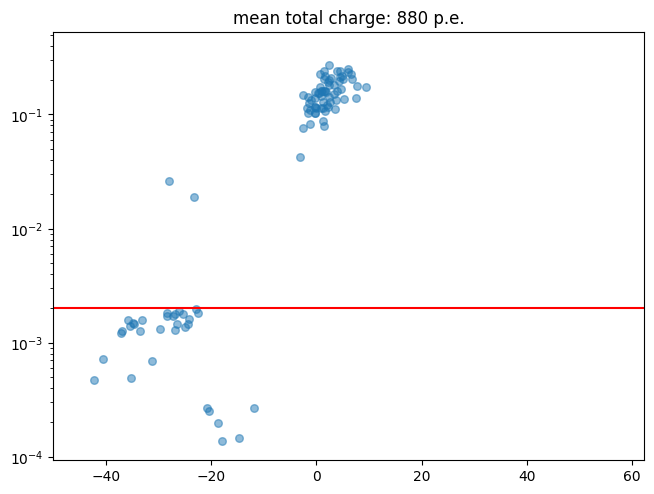

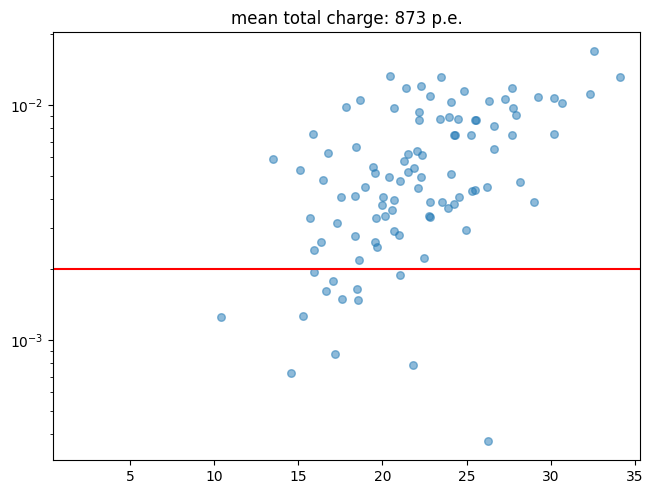

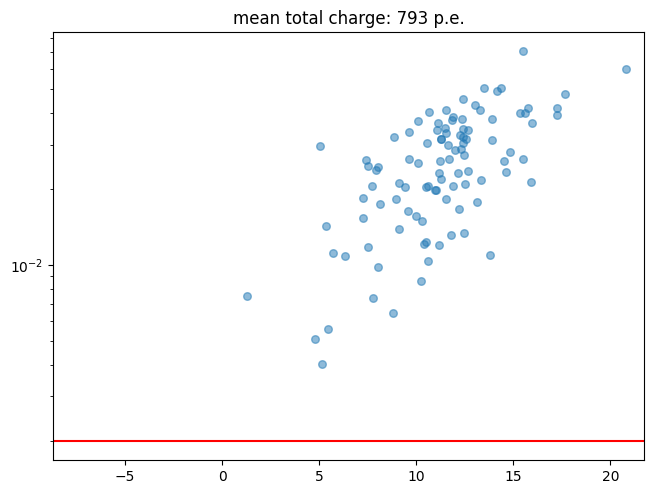

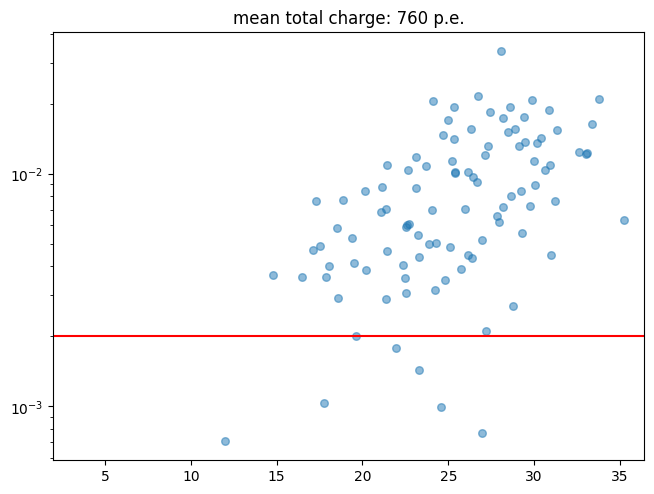

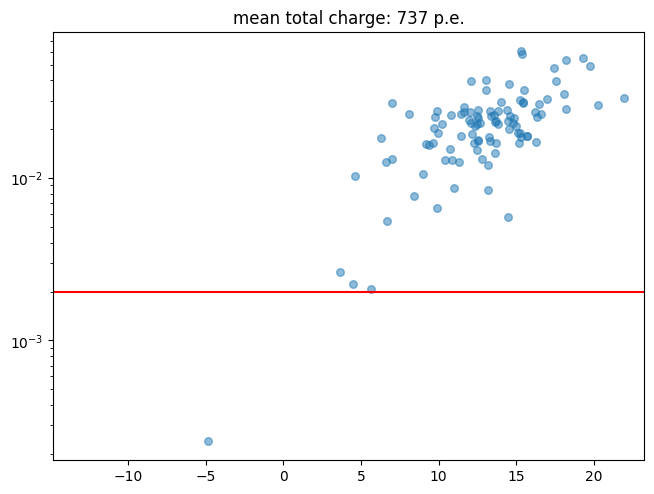

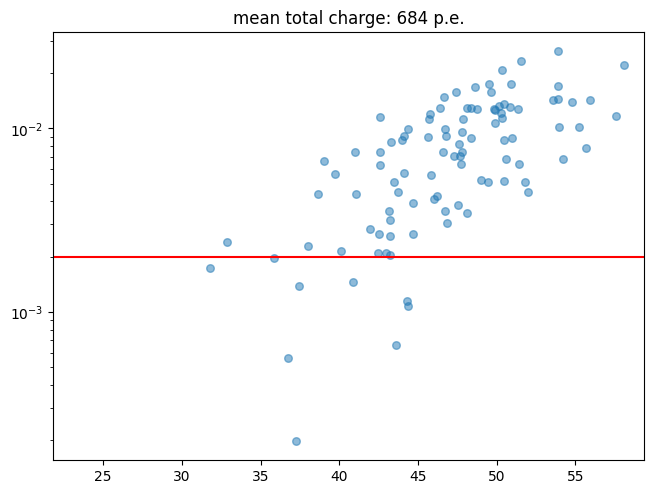

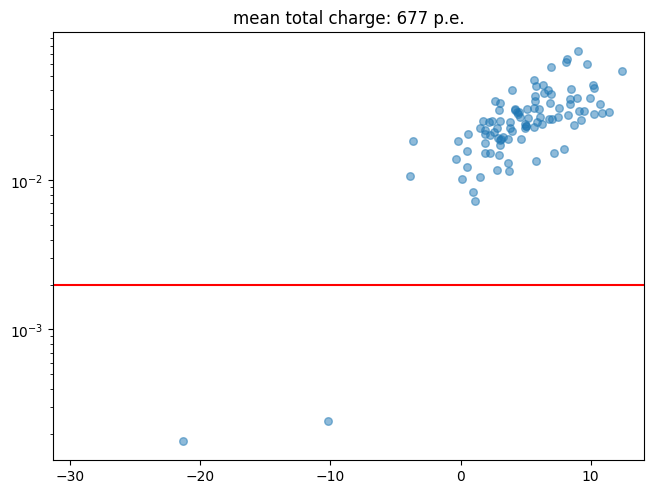

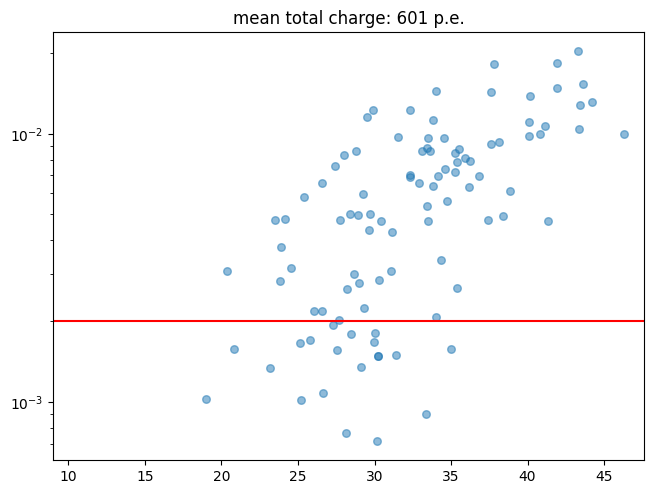

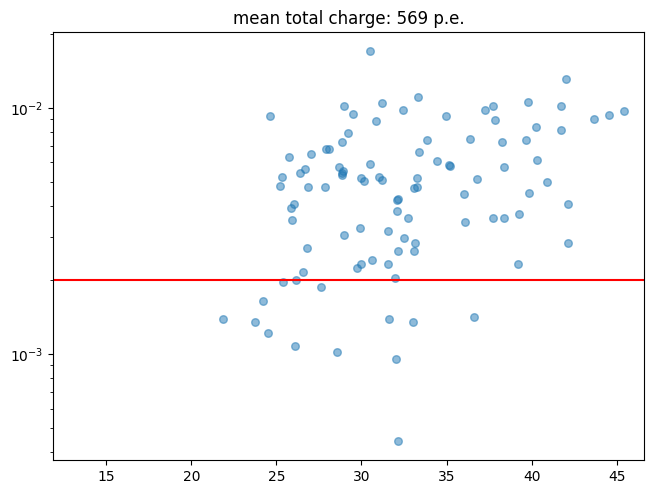

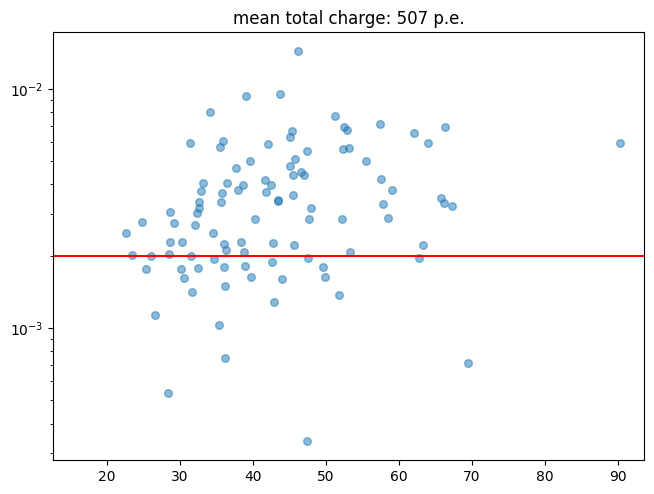

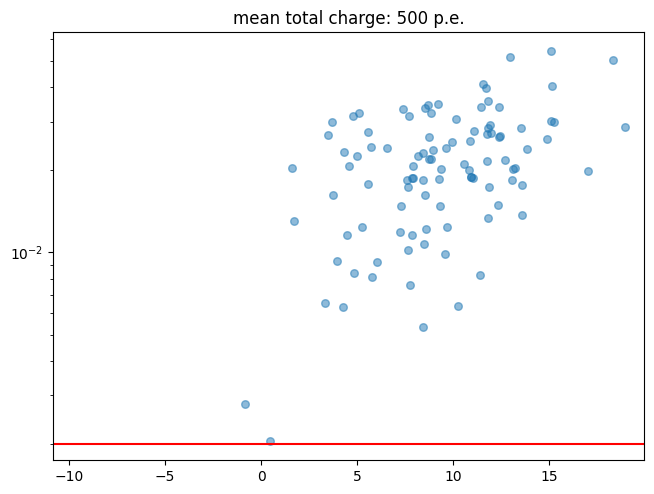

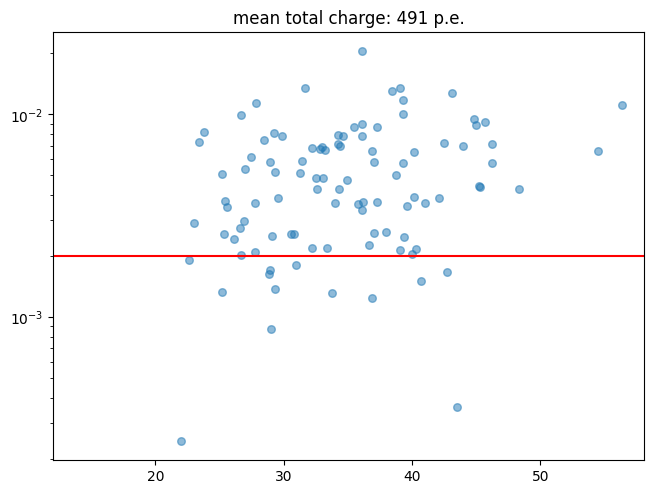

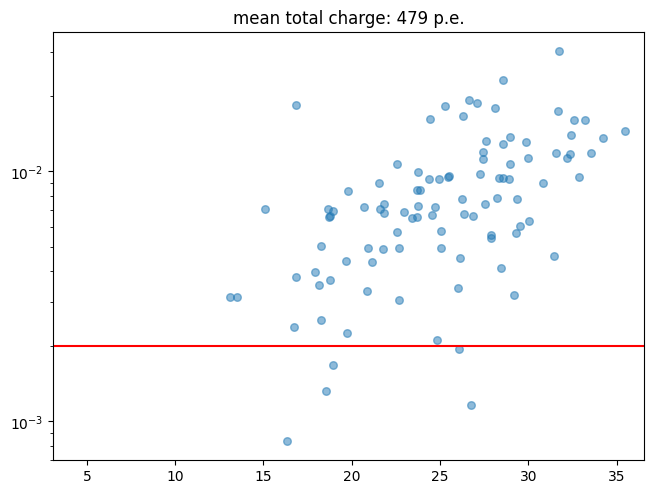

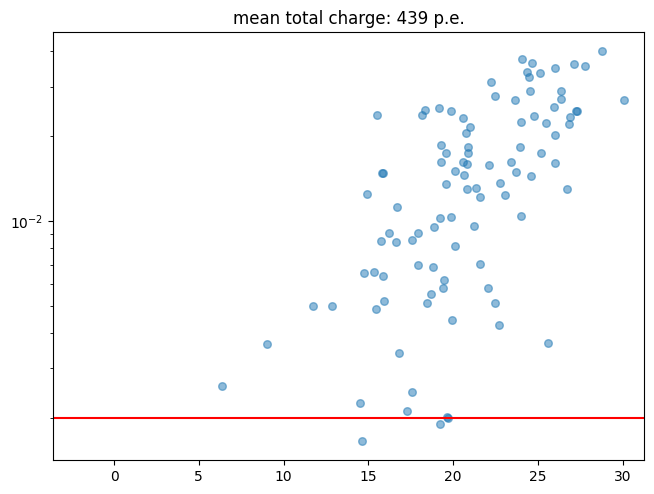

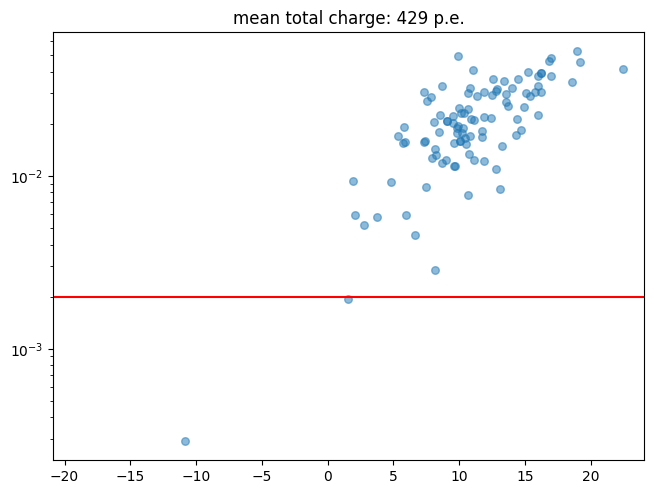

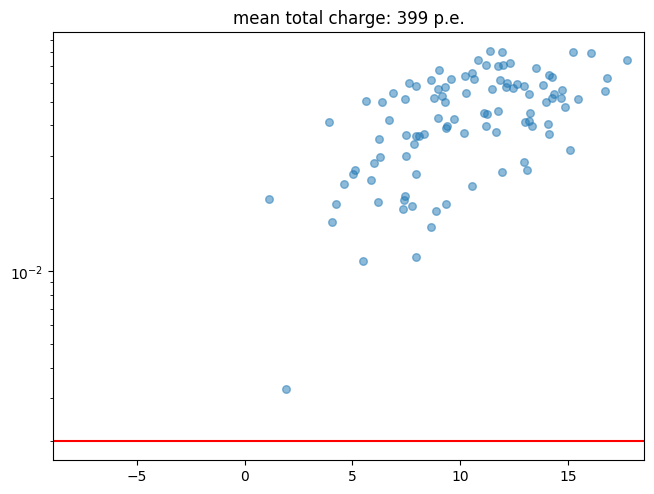

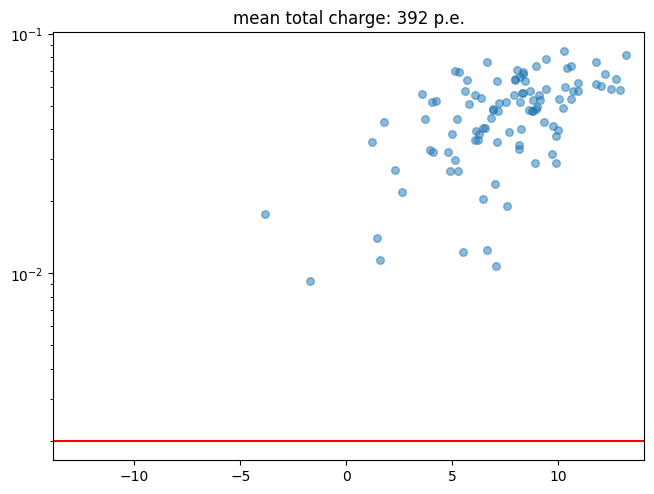

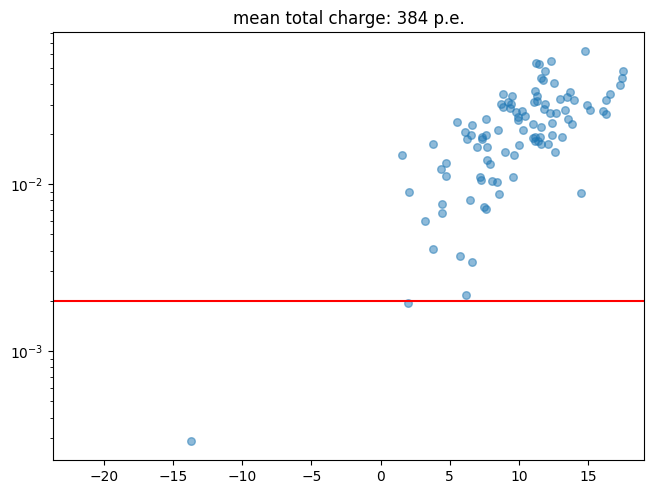

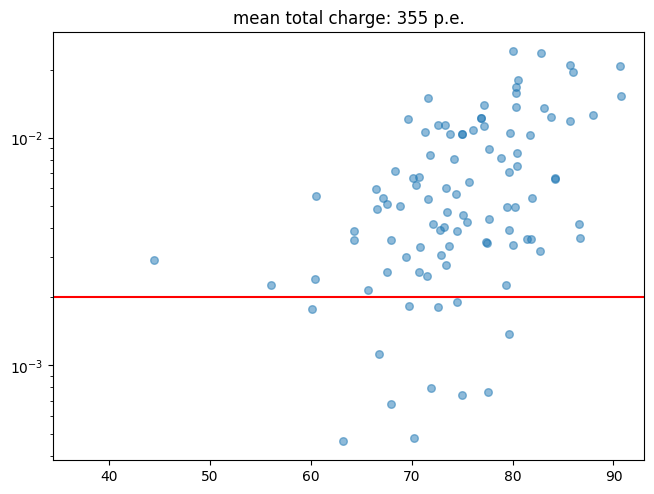

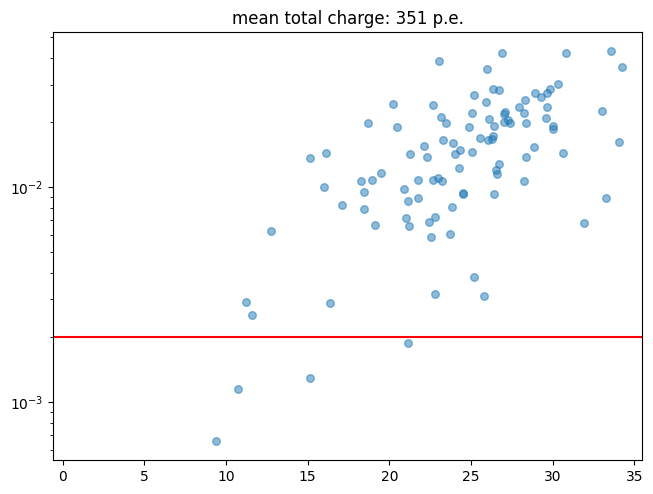

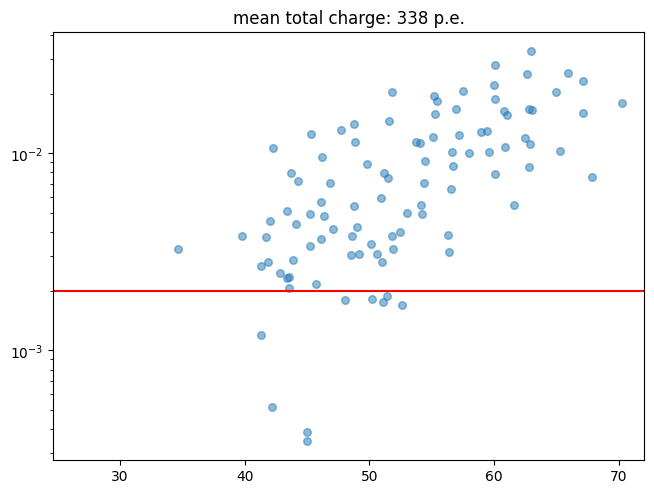

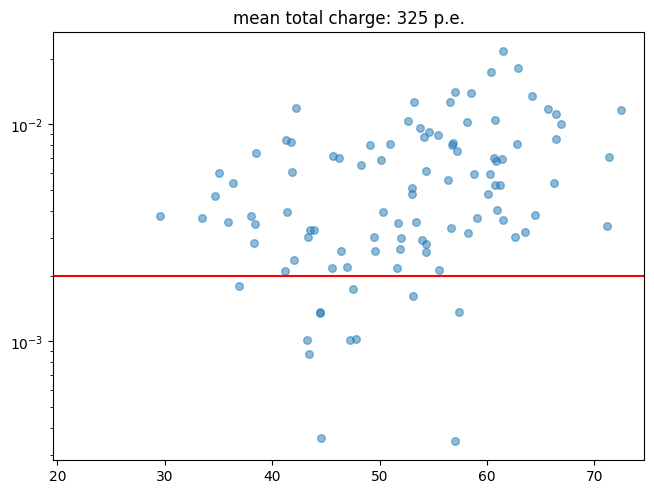

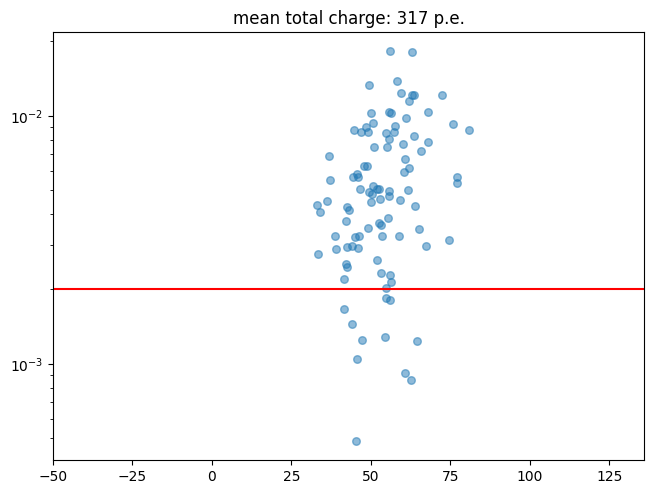

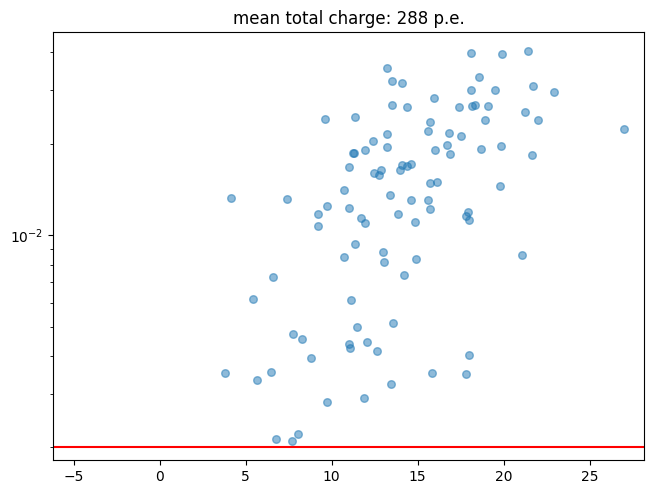

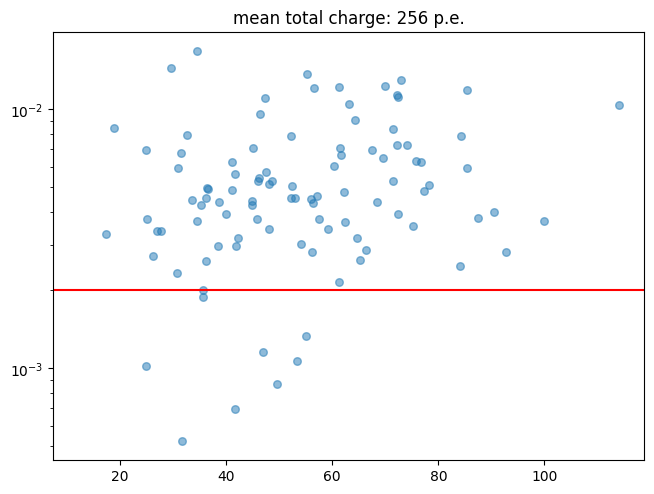

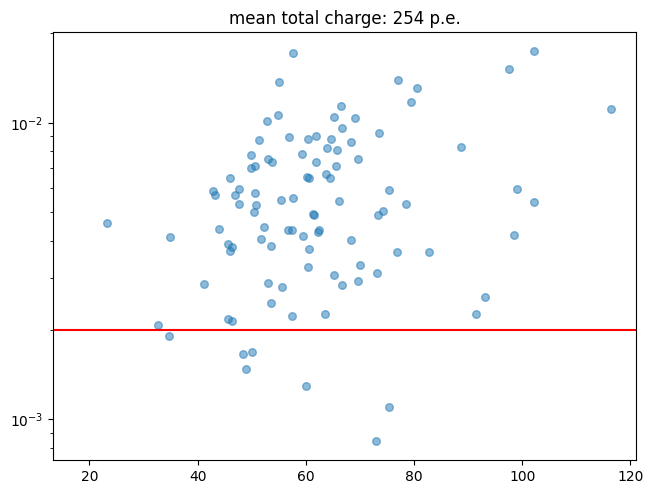

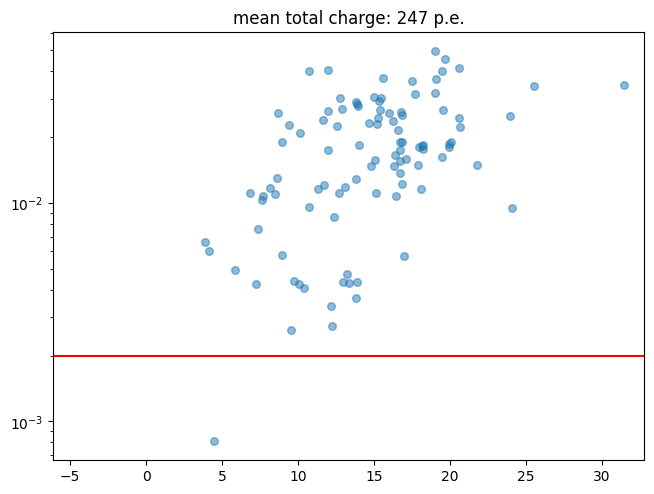

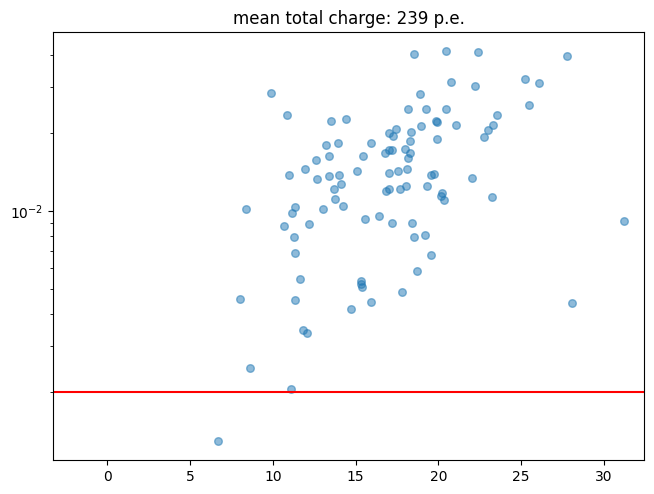

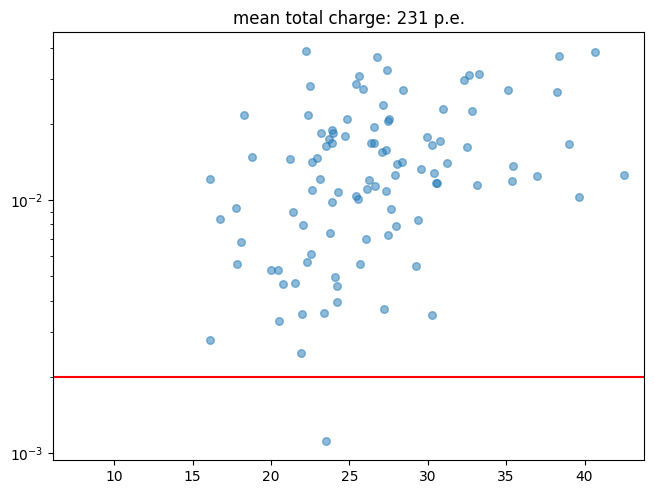

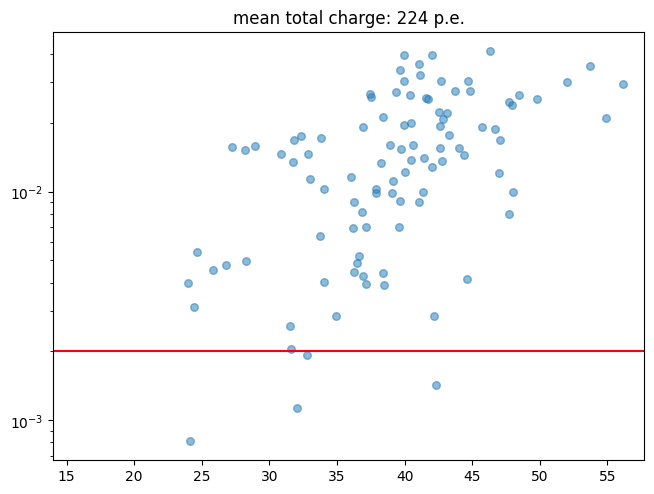

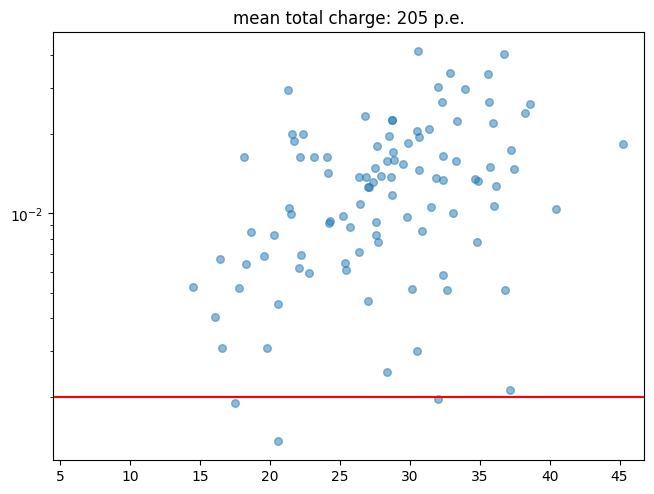

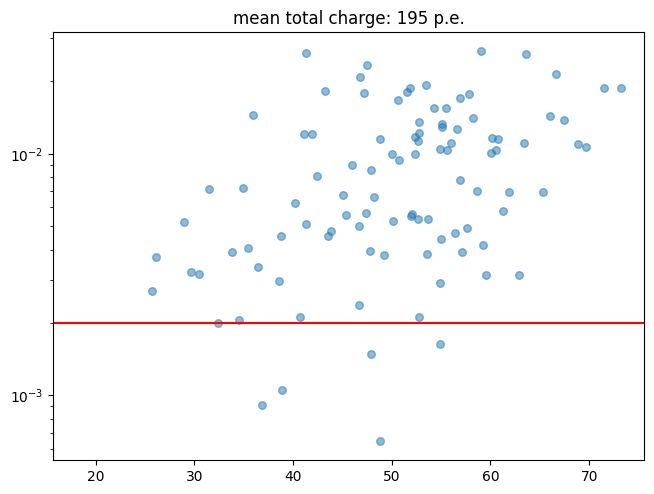

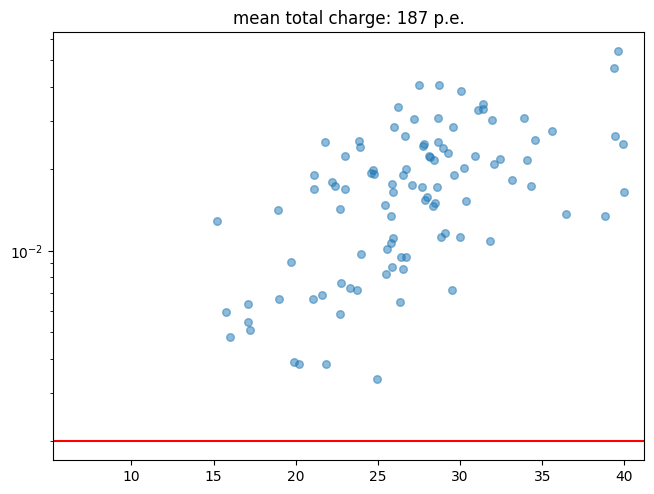

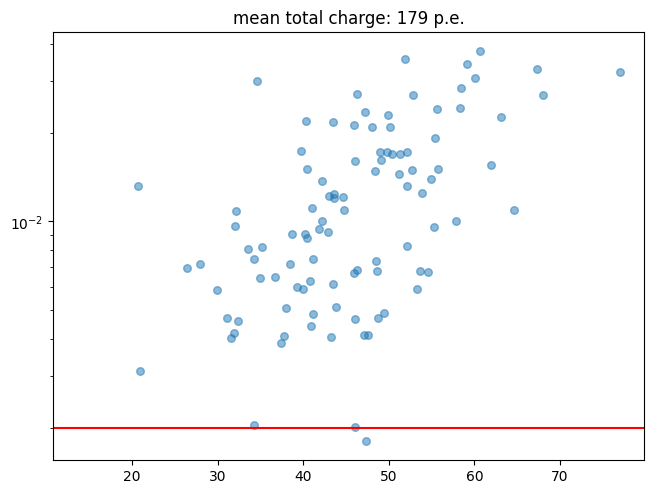

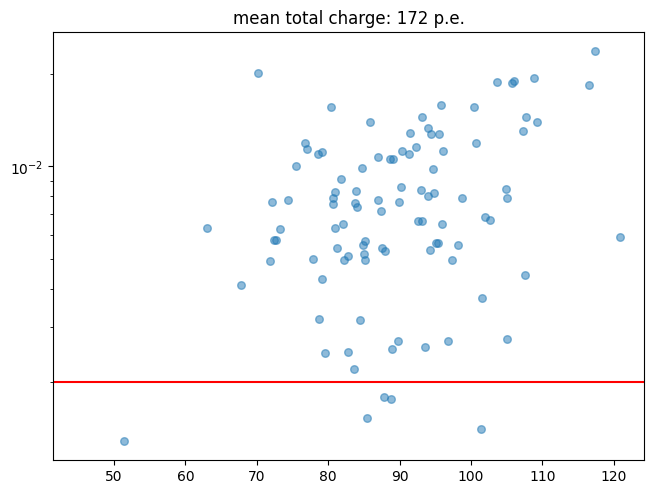

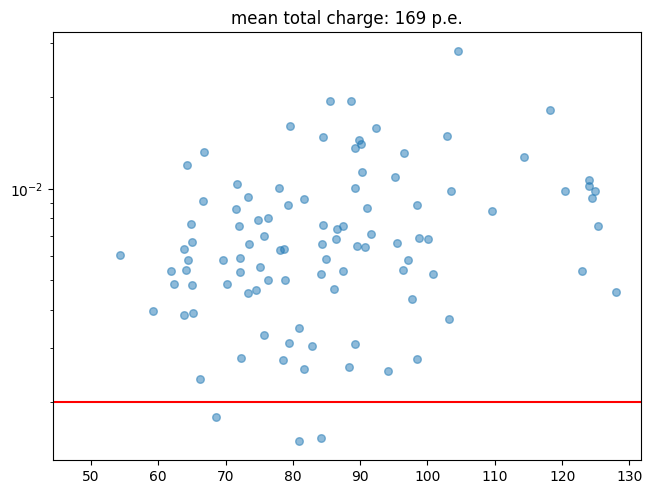

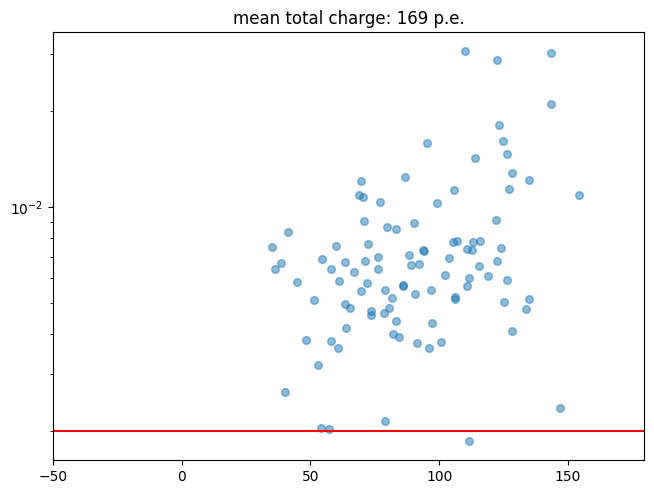

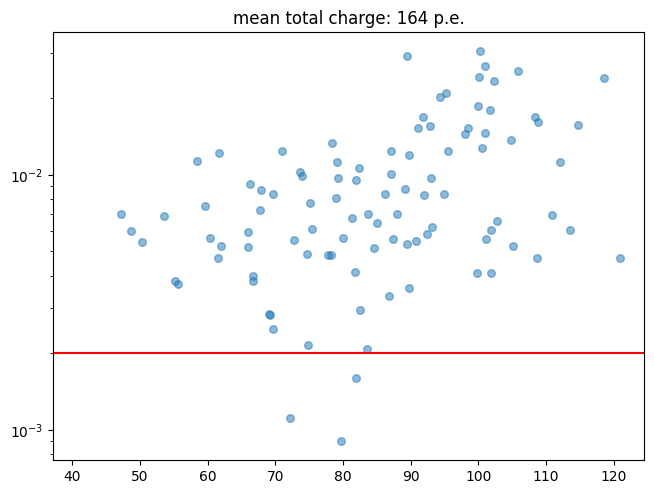

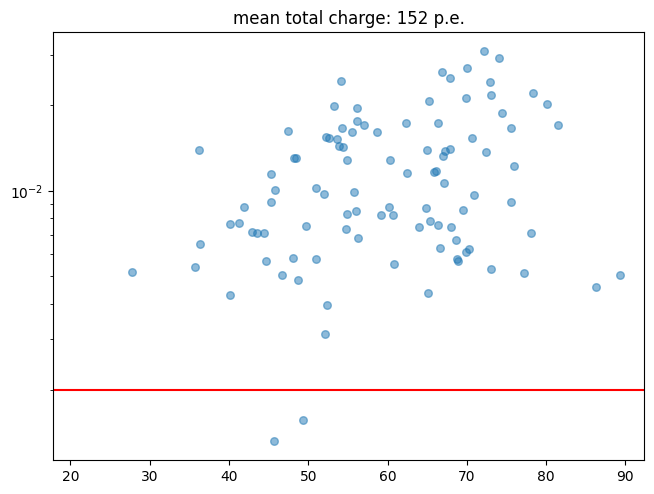

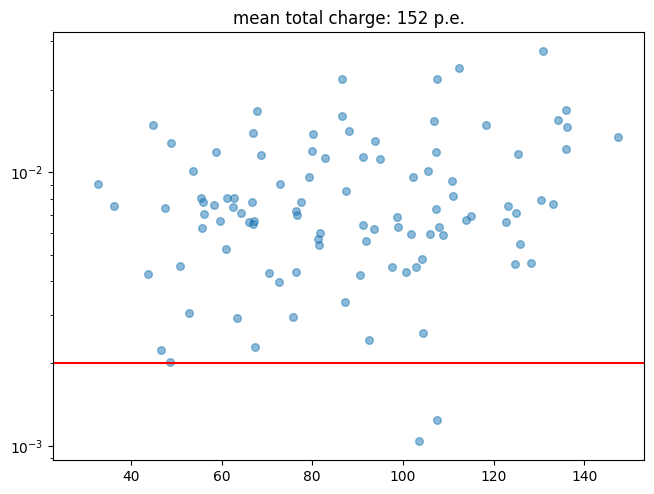

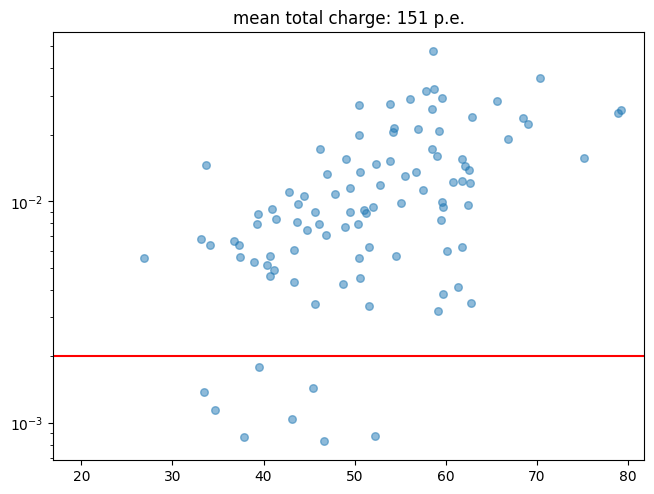

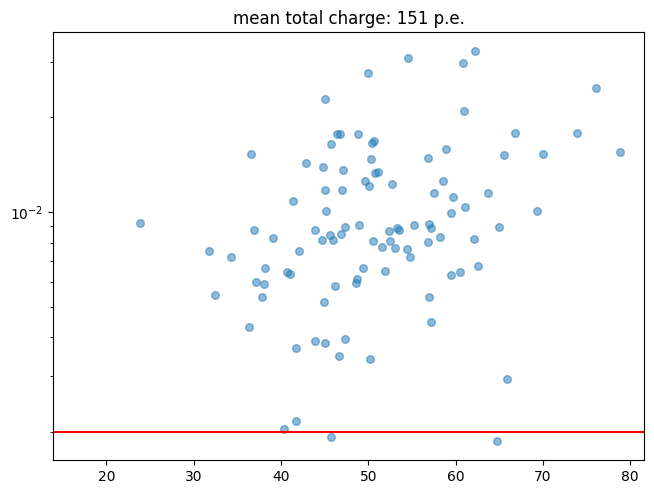

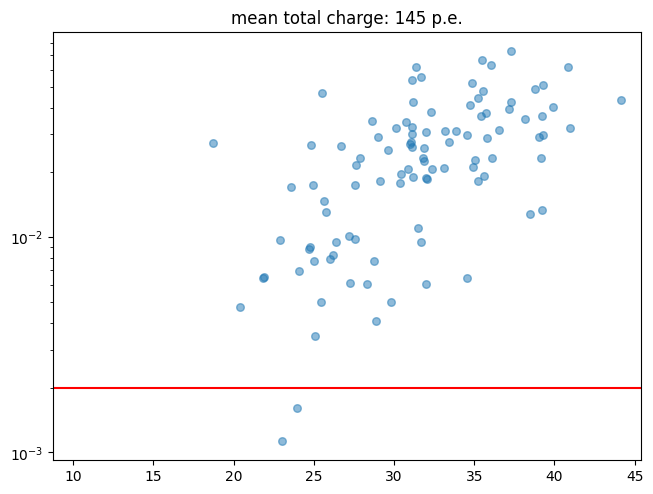

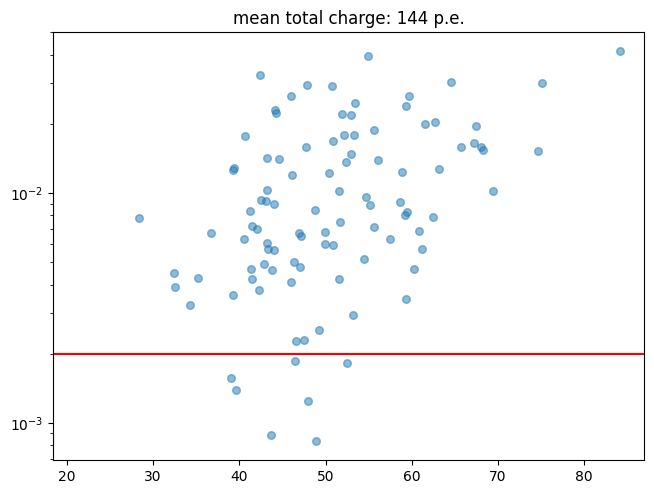

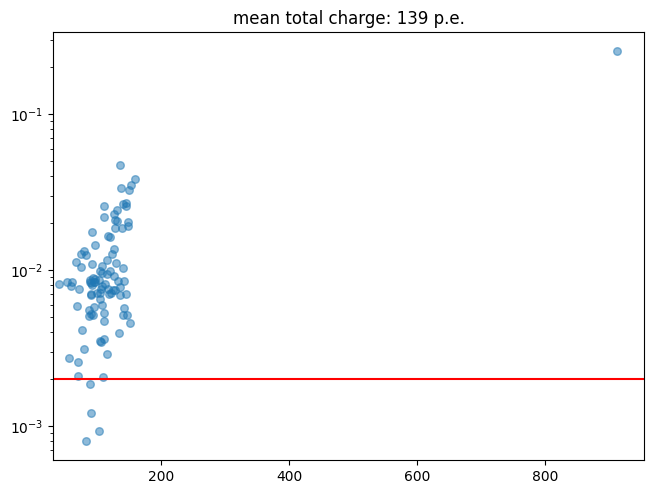

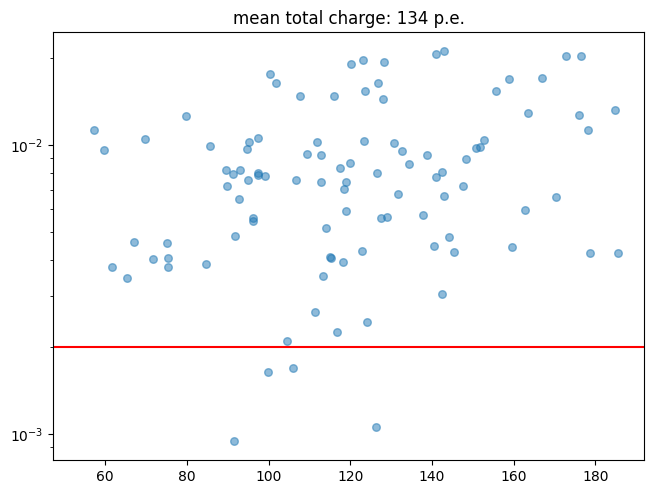

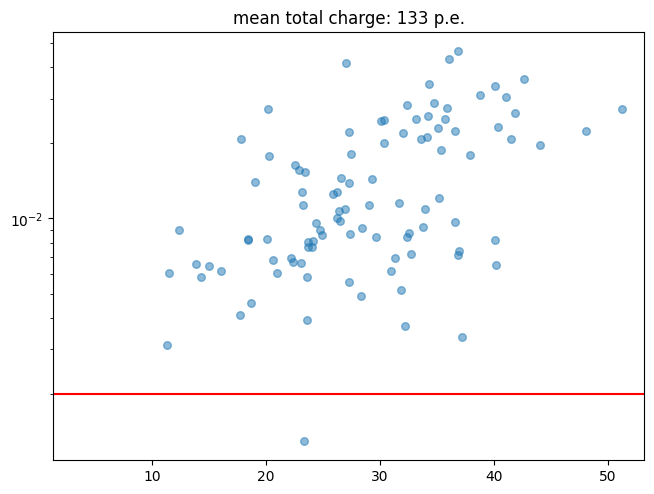

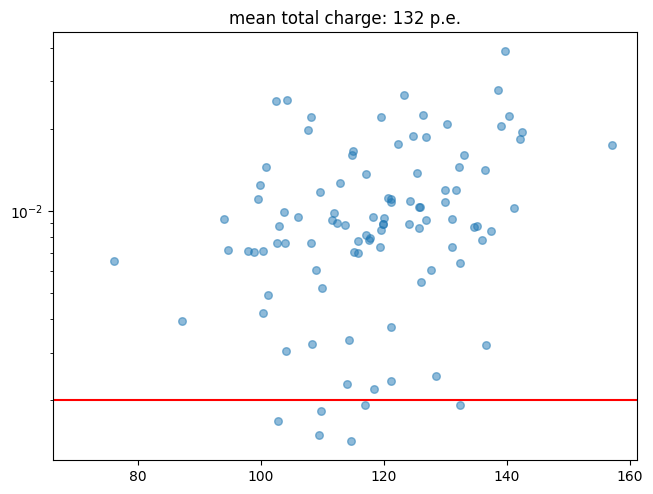

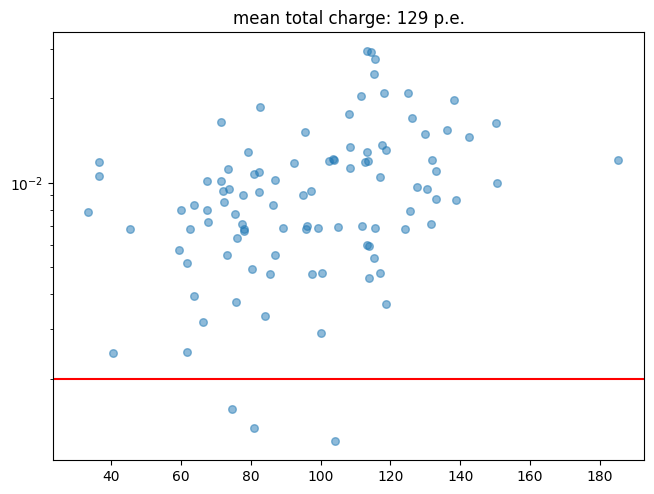

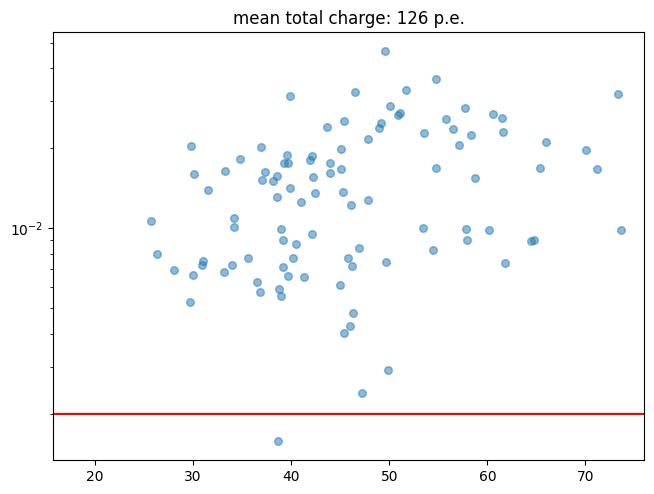

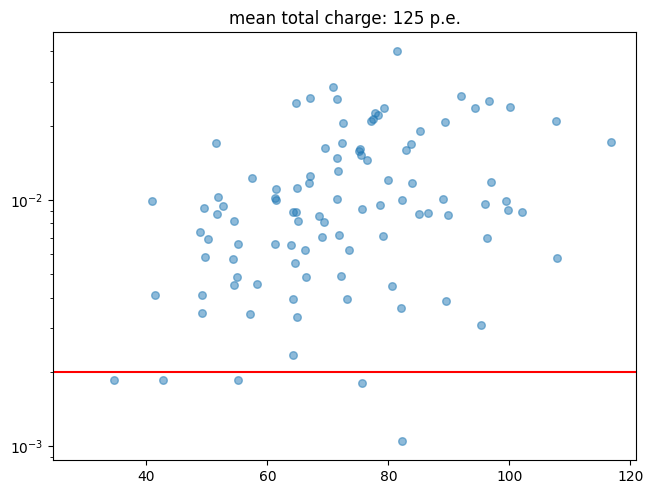

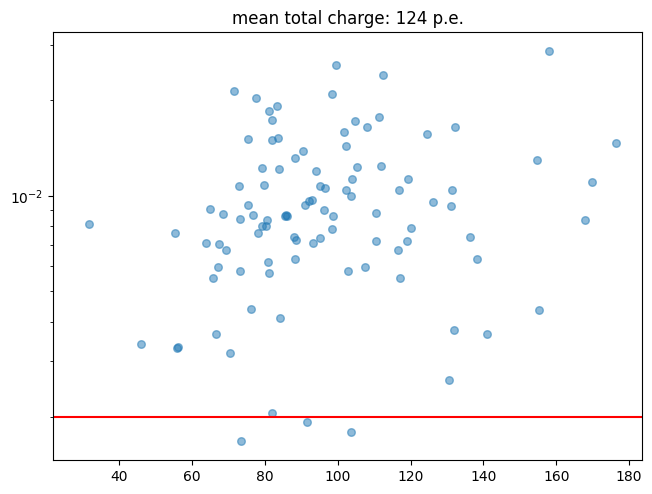

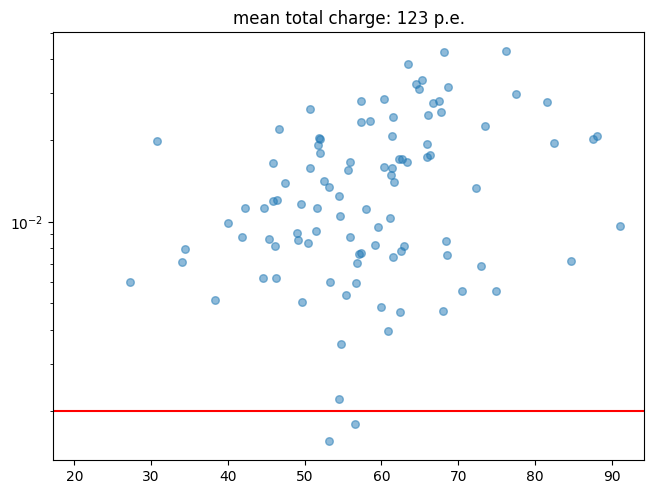

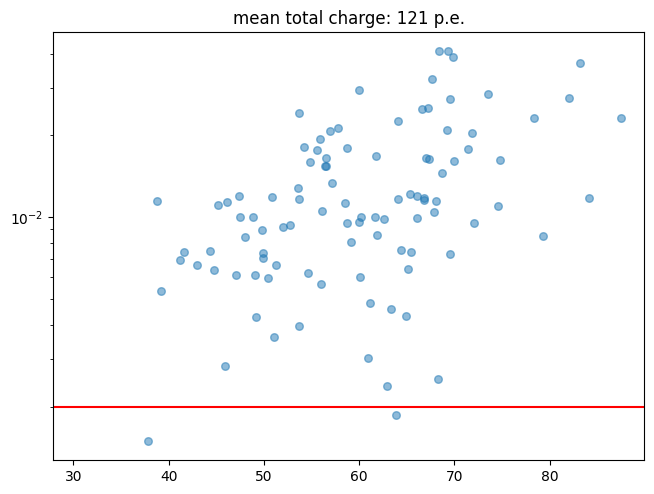

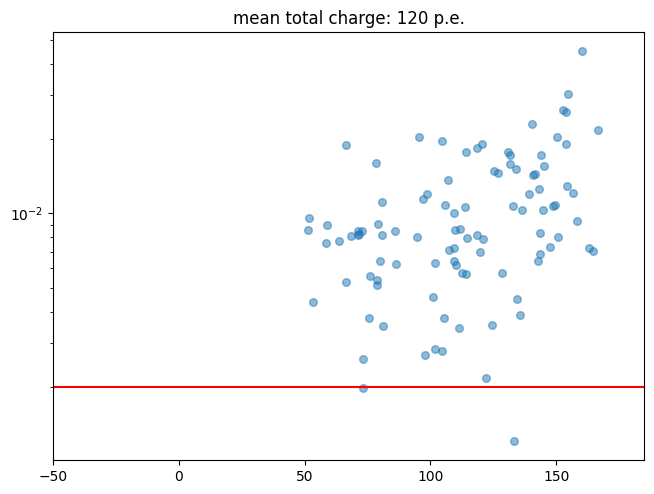

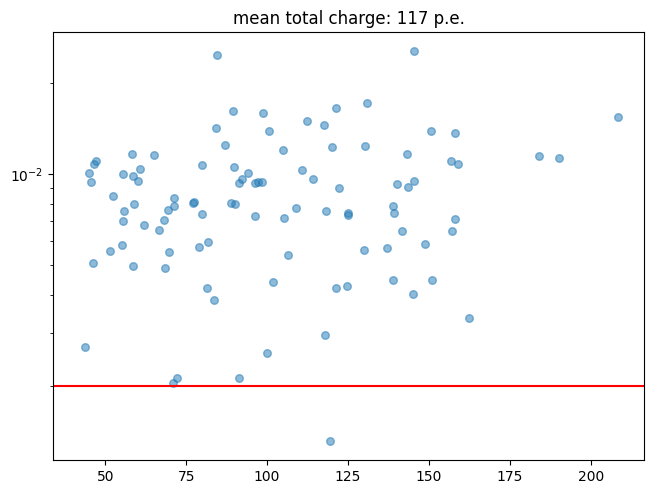

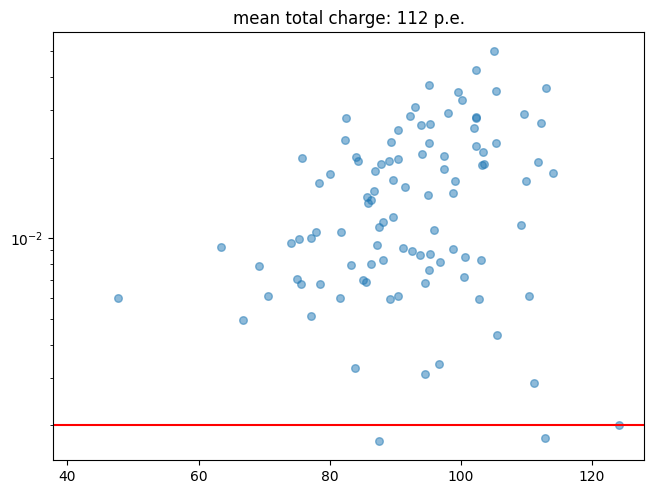

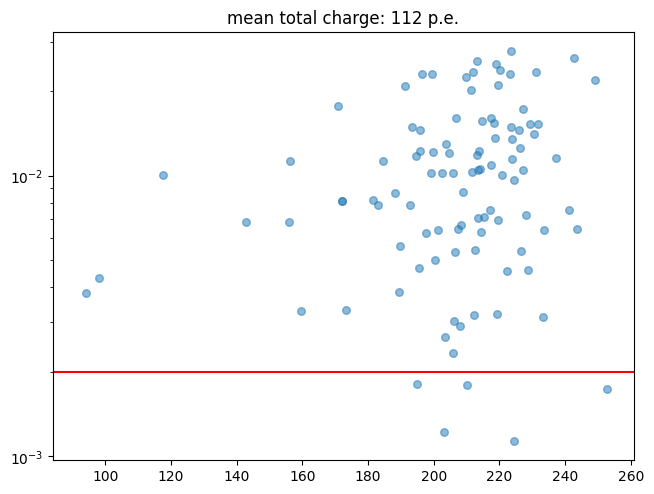

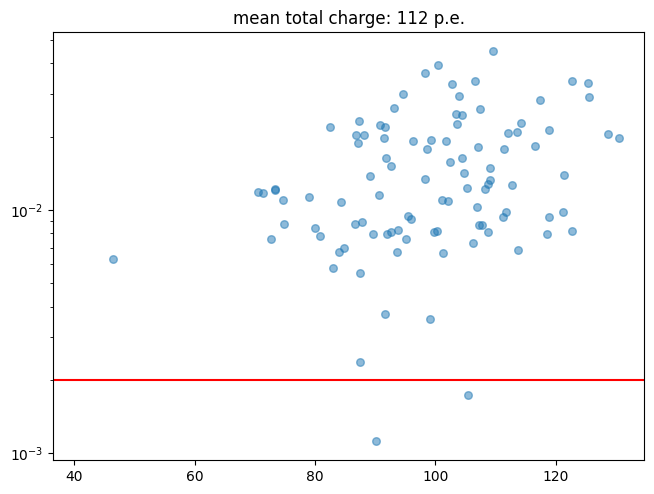

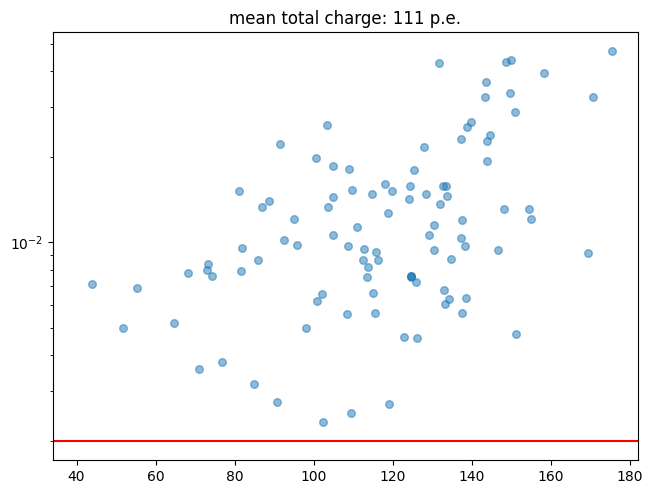

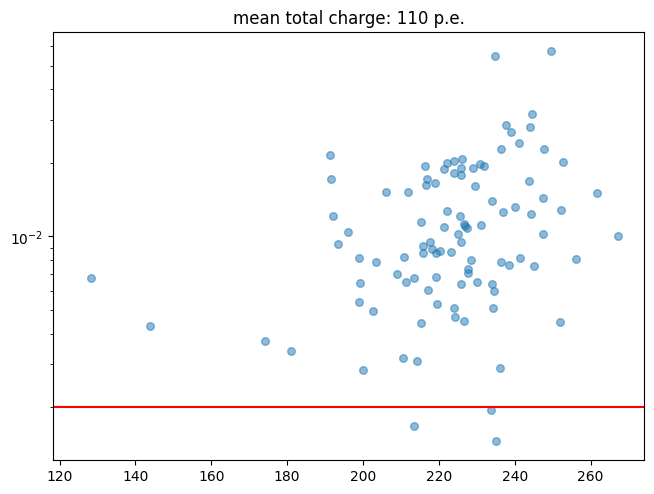

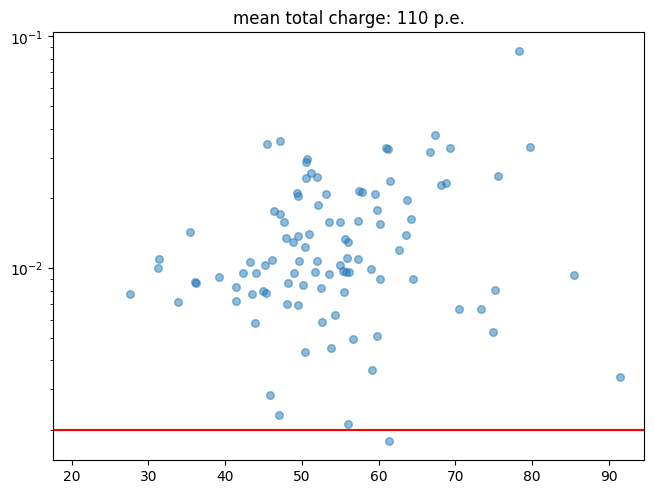

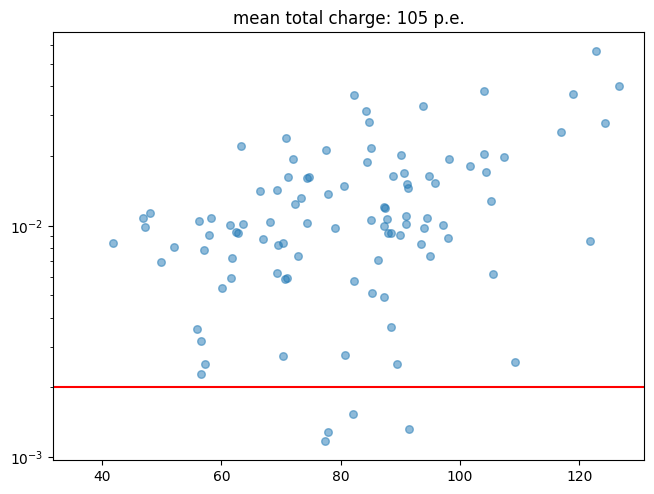

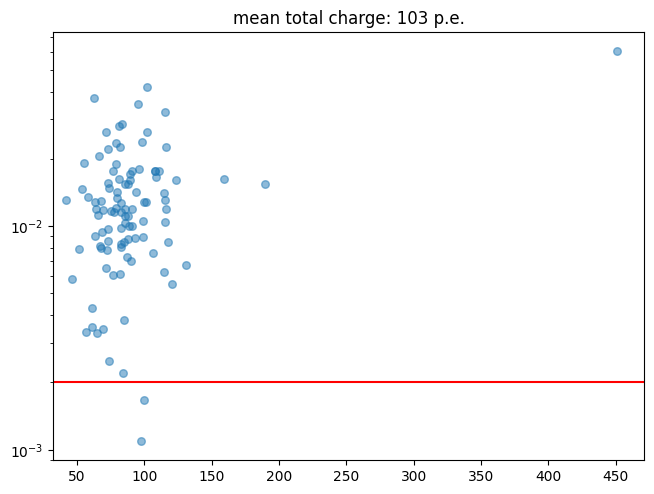

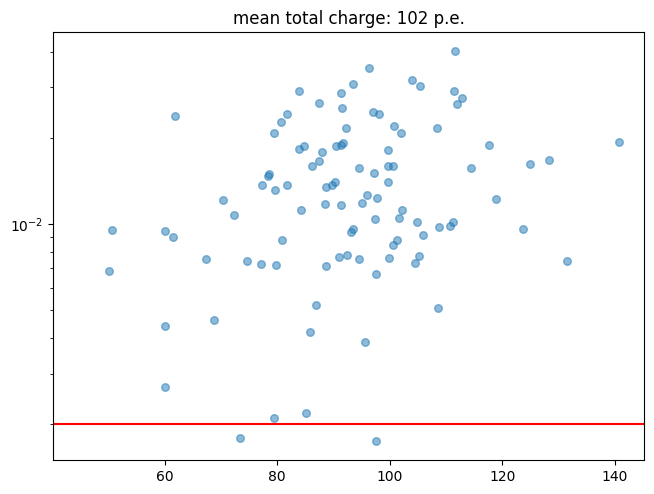

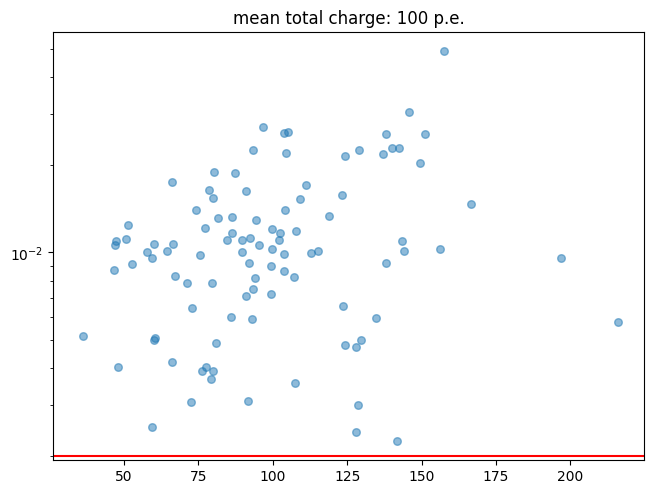

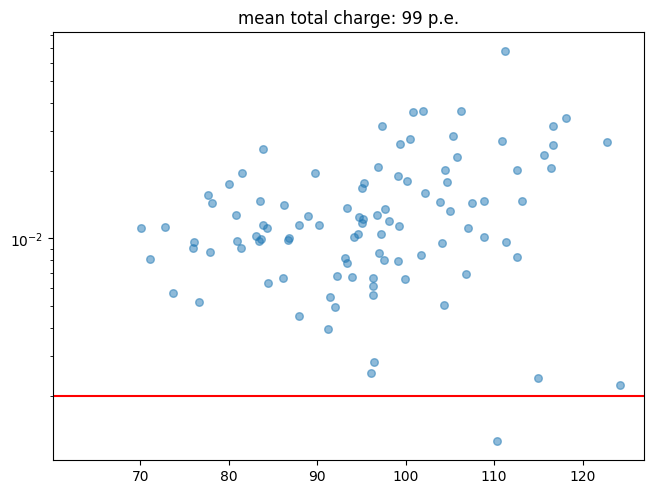

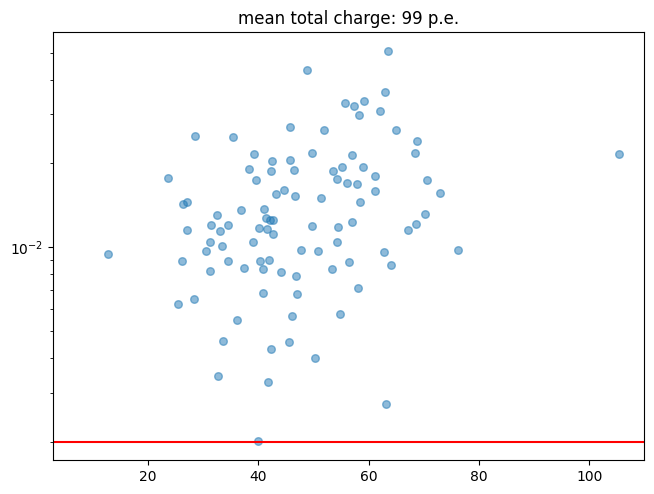

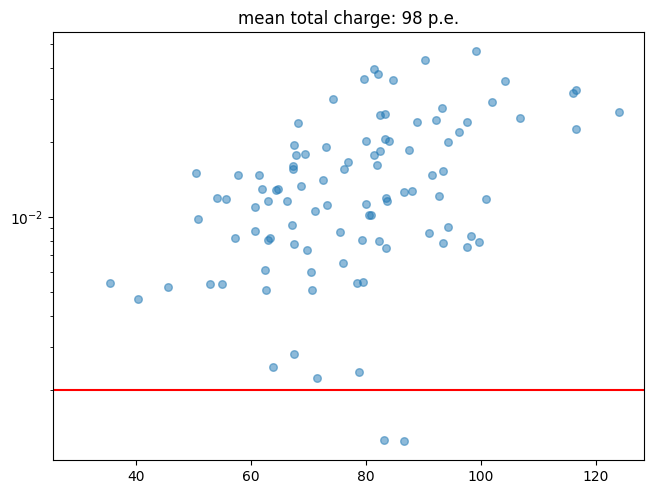

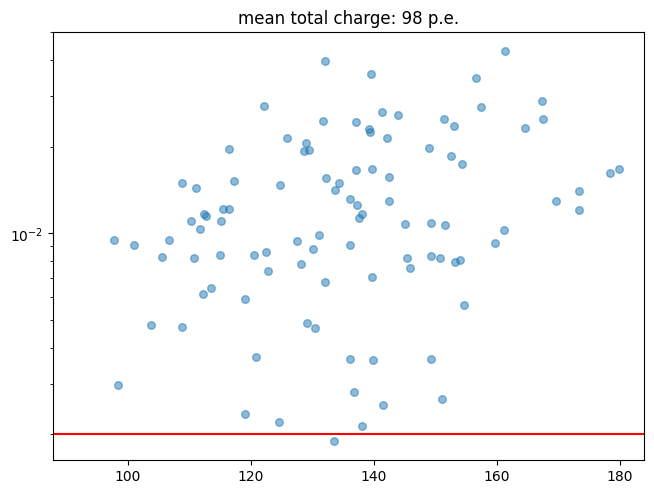

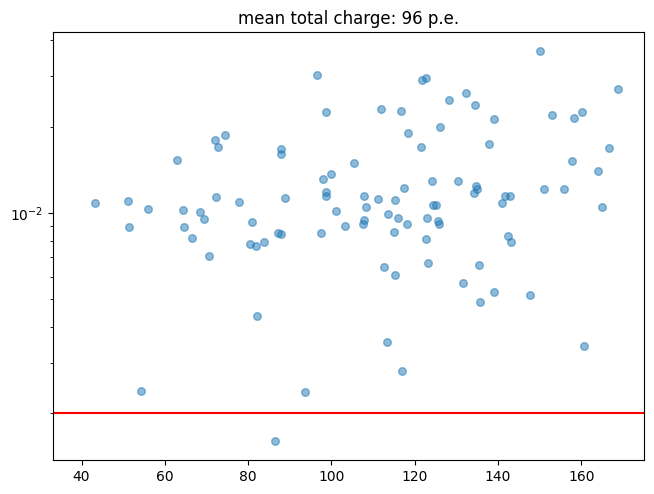

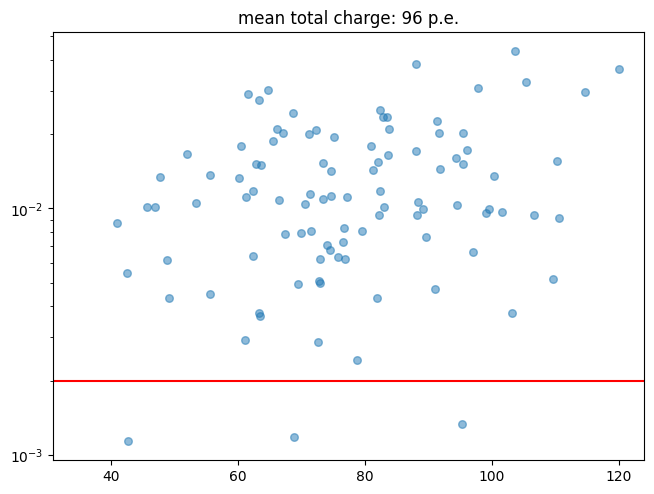

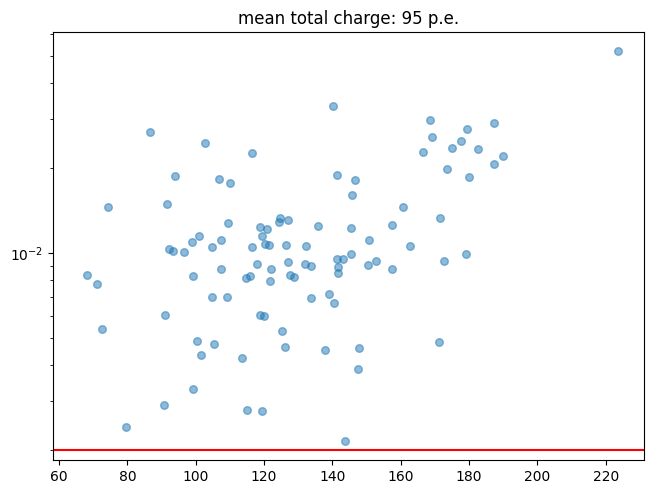

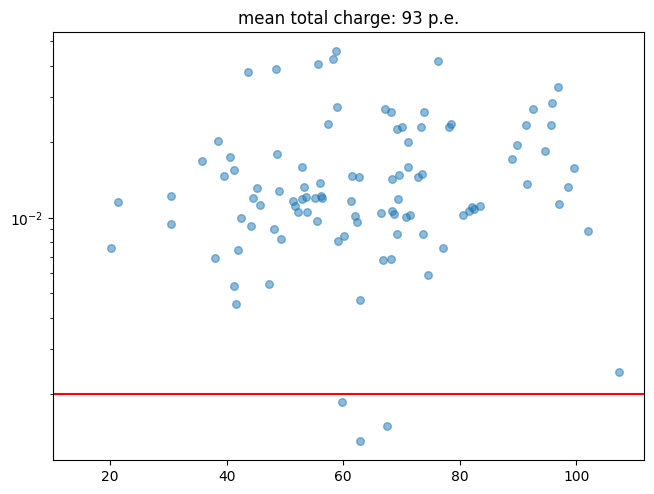

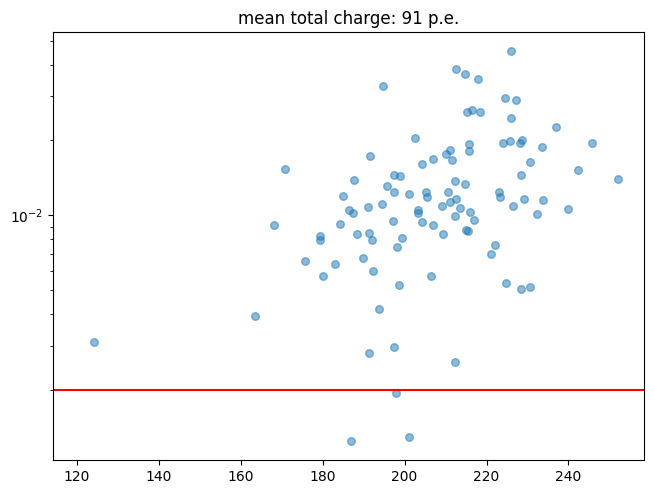

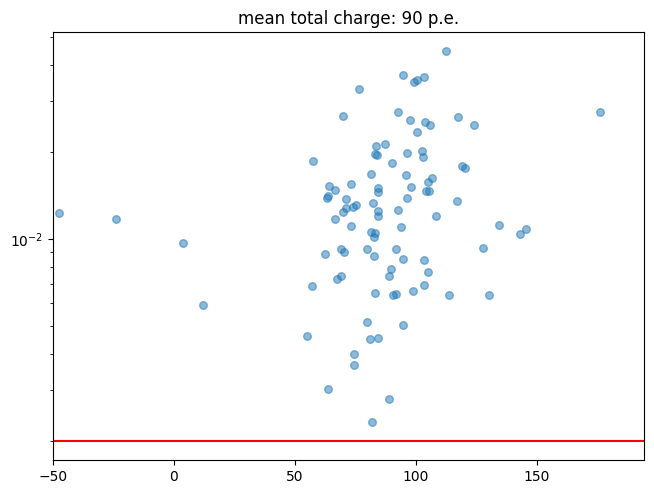

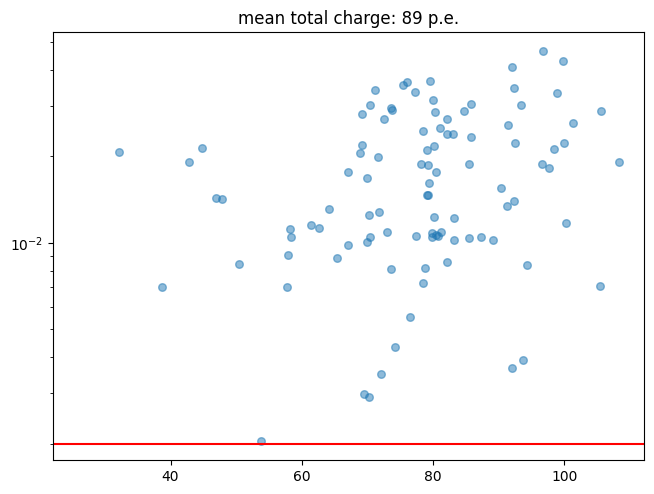

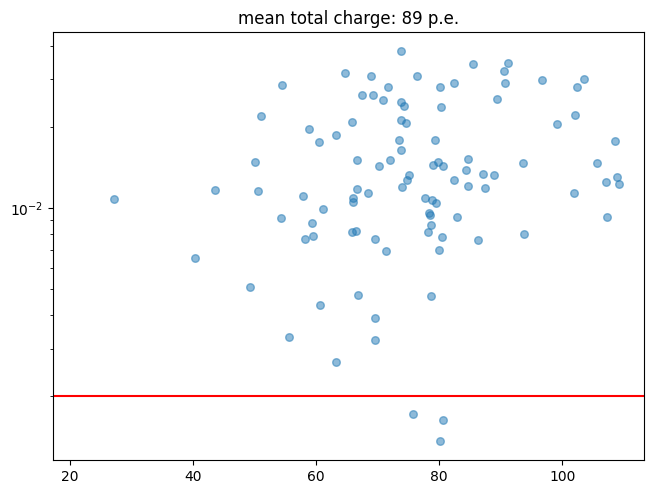

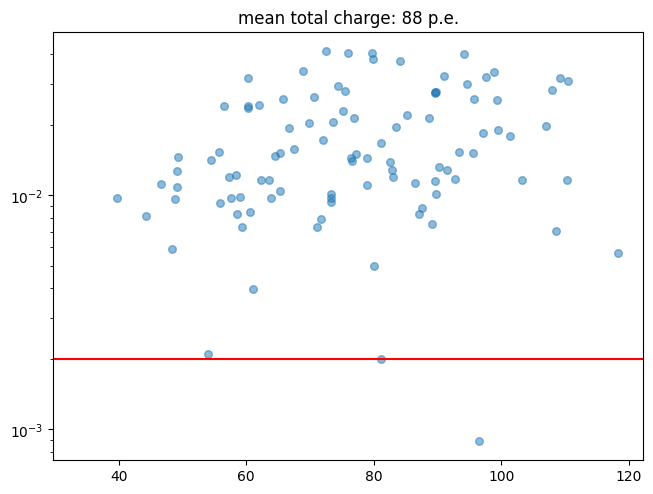

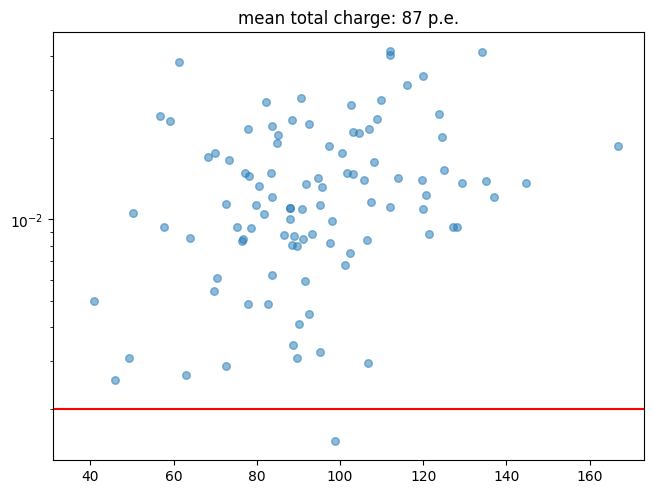

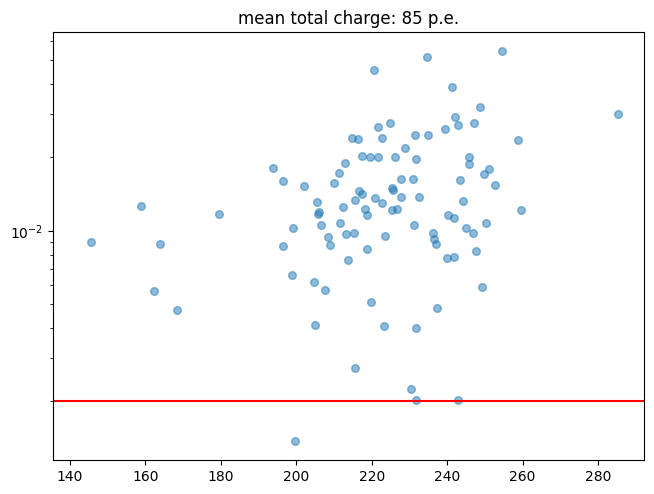

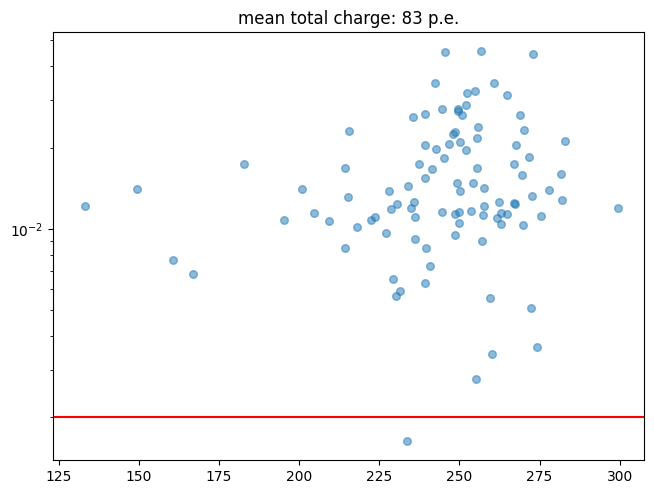

In [128]:
pos = dom_positions[0]
data = dom_data[tuple(pos)]

fig, ax = plt.subplots(1 ,3)

for i in range(3):
    ax[i].scatter(data['first_hit_time'], data[f'ratio_{delta_times[i]}'], s=30, alpha=0.5)
    ax[i].set_title(f"mean total charge: {data['mean_q_tot']:.0f} p.e.")
    ax[i].set_yscale('log')

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=1.0)
plt.show()

for i in range(100):
    pos = dom_positions[i]
    data = dom_data[tuple(pos)]
    
    fig, ax = plt.subplots()
    
    for i in range(1):
        ax.scatter(data['first_hit_time'], data[f'ratio_{delta_times[i]}'], s=30, alpha=0.5)
        ax.set_title(f"mean total charge: {data['mean_q_tot']:.0f} p.e.")
        ax.set_yscale('log')

    ax.axhline(y=2e-3, color='r')
    ax.set_xlim(xmin=max(-50, min(np.asarray(data['first_hit_time'])-10)))
    plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=1.0)
    plt.show()